### Import libraries

In [2]:
import os
import time
import json
import scipy as sp
import numpy as np
import pandas as pd
import tushare as ts
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# ingore warning
warnings.filterwarnings("ignore")  

from turtle import color
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Define function for modelling

In [8]:
def autoregression_model_pipeline(dataset, test_size, predict_size, lag_value):

    ''' Create and evaluate an updated autoregressive model and predict value in future

    Args: 
        dataset: one row/column dataframe with train data
        test_size: the number of test dataset size
        predict_size: the number of predict dataset size
        lag_value: selected lag value
    Returns: 
        a list of prediction values

    '''
    # split to train and test dataset
    X = dataset.values
    train, test = X[1:len(X)-test_size], X[len(X)-predict_size:]

    # train autoregression
    window = lag_value
    model = AutoReg(train, lags=lag_value)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    # train and predict value at next time steps
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]

        # predict yhat
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]

        # store the prediction result and the history value
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)

        # compare the value difference when training the model 
        if test_size != 0:
            print('predicted=%f, expected=%f' % (yhat, obs))

    # calculate the RMSE for model performance
    if test_size != 0:
        rmse = np.sqrt(mean_squared_error(test, predictions))
        print('Test RMSE: %.3f' % rmse)

        # generate plot
        num = [i for i in range(1, test_size+1)]
        fig, ax = plt.subplots(figsize = (10,6))
        plt.plot(num, test, color='darkred', label='Actual')
        plt.plot(num, predictions, color='coral', label='Predict')
        plt.xlabel('Timeline')
        plt.xticks(rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # return the result of prediction
    return predictions

In [9]:
def linear_model_function(x_train, y_train, x_predict):
    ''' Fit a simple linear regression OLS and predict value

    Args: 
        x_train: a list contains x train value
        y_train: a list contains y train value
        x_predict: x value for predicting
    Returns: 
        a dataframe contains all train values and prediction values

    '''
    # conver the list to dataframe
    train_df = pd.DataFrame()
    predict_df = pd.DataFrame()
    train_df['X'] = x_train
    train_df['Y'] = y_train
    predict_df['X'] = x_predict

    # fit ols model
    linear_model = sm.formula.ols('Y ~ X', data = train_df).fit()
    print(linear_model.summary())

    # model prediction
    y_predict = linear_model.predict(exog=predict_df['X'], transform=True)
    predict_df['Y'] = y_predict
    print(linear_model.params)

    # merge train and predict dataset form a final dataset
    merge_list = [train_df, predict_df]
    final_df = pd.concat(merge_list)
    return final_df

In [14]:
def convert_suburb(df):
    ''' Convert all suburbs into numeric

    Args:
        dataframe contains suburb
    Return:
        dataframe with numeric suburb
    '''

    # put unique suburb into list
    suburb_lis = list(df['suburb'].unique())

    # convert
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)

    # return dataframe
    return df

In [15]:
def similar(a, b):
    ''' Calculate the similarity percentage
    
    Args:
        a: standard suburb name
        b: suburb name from address
    Return:
        match ratio of a and b string
    '''
    return SequenceMatcher(None, a, b).ratio()

def most_similar(df,suburb):
    '''Find the most similar suburb
    
    Args:
        df: property dataframe
        suburb: standard suburb name
    Return:
        most matchable suburb name
    '''

    if df['suburb'].shape[0] == 1:
        current_match = [100,df['suburb'].iloc[0][0]]
    else:

        # initialize the most similar suburb
        current_match = [0,"None"]

        # check similarity for each suburb
        for sub in df['suburb']:

            # get the similarity percentage
            simi_percent = similar(suburb, sub)

            # update most similar suburb
            if simi_percent > current_match[0]:
                current_match = [simi_percent, sub]
                
    # return the most similar suburb
    return current_match[1]

def correct_suburb(suburb_df, df):
    ''' Find correct suburb
    
    Args:
        suburb_df: standard postcode suburb match dataframe
        property_df: property dataframe
    Return:
        property dataframe with correct suburb name
    '''

    # check property_df each row's suburb
    for row in range(df.shape[0]):

        # all the suburb names
        sub_lis = list(set(suburb_df.suburb.sum()))

        # if the suburb matched, don't change it
        if df.loc[row, 'suburb'] in sub_lis:
            pass

        # if the suburb don't matched, replace by the most similar suburb by postcode
        else:
            most_match = most_similar(pd.DataFrame.from_dict({'suburb':sub_lis}), df.loc[row, 'suburb'])
            df.at[row, 'suburb'] = most_match
            
    # return dataframe
    return df

In [16]:
def get_0(lis):
    ''' Get index 0 of a list

    Args:
        list
    Return:
        return the 1st element in the list
    '''

    # return 0 index in list
    return lis[0]

def delete_space(string):
    ''' Delete space in string

    Args:
        string
    Return:
        string without space
    '''

    # check is the string contains sapce at the end
    if string[-1] == ' ':

        # return string
        return string[:len(string)-1]

    # else
    else:

        # return string
        return string

def replace_word(string):
    ''' Clean string

    Args:
        string
    Return:
        cleaned string
    '''

    # replacing
    string = string.replace(' (SOUTH)','')
    string = string.replace(' (NORTH)','')
    string = string.replace(' (VICNP)','')
    string = string.replace(' (WEST)','')
    string = string.replace('ST KILDA EAST','ST KILDA')
    string = string.replace(' (EAST)','')
    string = string.replace(' INDUSTRIAL','')
    string = string.replace('MELBOURNE CBD','MELBOURNE')
    string = string.replace(' INDUSTRIAL','')
    string = string.replace(' (VIC.)','')
    string = string.replace('  ','')

    # return the string
    return string

## Modelling and Prediction

### Predict population

In [14]:
# read population data and extract train dataset
population = pd.read_csv("../data/curated/population.csv")
population_data = population.loc[:, '2001_population': '2021_population'].copy()
sa2 = population[['SA2_Code', 'SA2_name']].copy()

#### Using auto-regression model

use example to check the performance of model

In [15]:
example_population = population_data.iloc[10,:].copy()

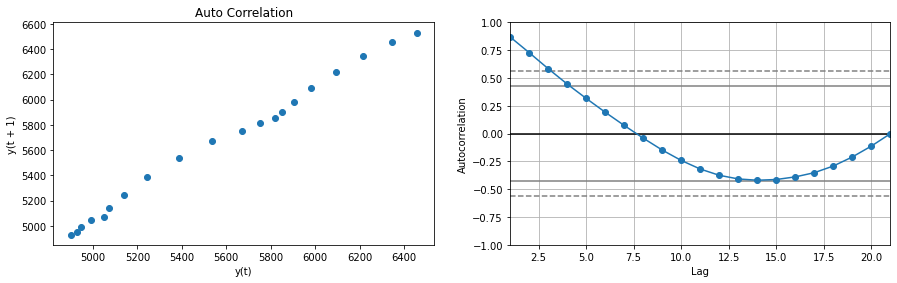

In [16]:
# plot auto correlation
plt.figure(figsize=(15,9))
plt.subplot(221)
lag_plot(example_population)
plt.title('Auto Correlation')

# plot the figure to select lag value
plt.subplot(222)
autocorrelation_plot(example_population, marker='o')
plt.show()

predicted=6099.857937, expected=6093.000000
predicted=6223.776029, expected=6217.000000
predicted=6340.334745, expected=6344.000000
predicted=6448.677423, expected=6457.000000
predicted=6542.497068, expected=6533.000000
Test RMSE: 7.292


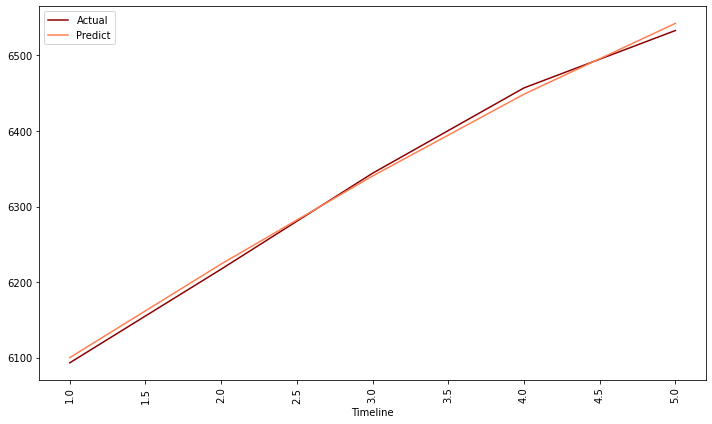

In [17]:
# use example to fit the model and check model performance
lag_value = 5
test_size = 5
example_result = autoregression_model_pipeline(example_population, test_size, test_size, lag_value)

In [18]:
# get the name of timesteps
population_col = population_data.columns.to_list()
population_pred_col = ['2022_population',
                        '2023_population',
                        '2024_population',
                        '2025_population',
                        '2026_population',
                        '2027_population']
population_col.extend(population_pred_col)

predict 5 year population

In [19]:
# train the whole dataset and predict 6 year result
predict_year = 6
test_size = 0
population_result_df = pd.DataFrame()
lag_value = 5

index = 0
while index < len(population_data):

    # fit the model
    predictions = autoregression_model_pipeline(population_data.iloc[index,:], test_size, predict_year, lag_value)

    # append each prediction
    total_value = population_data.iloc[index,:].to_list()
    total_value.extend(predictions)

    # change the dimension and save to dataframe
    temp = pd.DataFrame()
    temp = temp.append(total_value).transpose()
    population_result_df = population_result_df.append(temp).reset_index(drop=True)
    index += 1

# set the column name and add sa2 column
population_result_df.columns = population_col
population_result_df['SA2_Code'] = sa2['SA2_Code']
population_result_df['SA2_name'] = sa2['SA2_name']

# save the population data
population_result_df.to_csv('../data/curated/predict_population_AutoReg.csv', index=False)


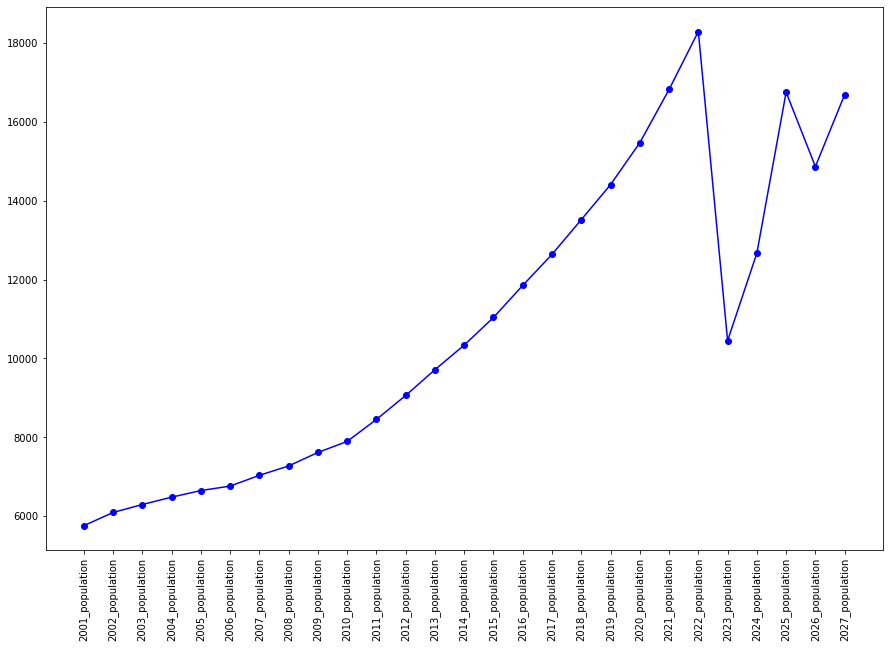

In [20]:
# plot one instance to see the result
plt.figure(figsize=(15,10))
plt.plot(population_col, population_result_df.iloc[0,:27], color='b', marker='o')
plt.xticks(rotation=90)
plt.show()

#### Using linear ols

In [21]:
# find the training time steps
year = []
for i in population_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))

In [22]:
# use one instance as example to check r-square for the model
INDEX = 0
population_result_df = pd.DataFrame()
population_value = population_data.iloc[INDEX, :].to_list()
predict_year = [22,23,24,25,26,27]

# set the last 6 years data as test data
population_final_df = linear_model_function(year[:-6], population_value[:-6], year[-6:])
result = [population_result_df, population_final_df.transpose()]
population_result_df = pd.concat(result)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     171.0
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           7.40e-09
Time:                        20:00:25   Log-Likelihood:                -111.80
No. Observations:                  15   AIC:                             227.6
Df Residuals:                      13   BIC:                             229.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4959.1333    243.672     20.352      0.0

In [23]:
# The mean squared error
rmse = np.sqrt(mean_squared_error(population_result_df.iloc[1, -6:].copy(), population_value[-6:]))
print("Train RMSE is: ", rmse)

Train RMSE is:  2887.2086189682304


In [ ]:
# train all population and predict future population for each region
population_result_df = pd.DataFrame()
for index in range(len(population_data)):
    population_value = population_data.iloc[index, :].to_list()

    # fit the linear model
    population_final_df = linear_model_function(year, population_value, predict_year)
    result = [population_result_df, population_final_df.transpose()]
    population_result_df = pd.concat(result)

In [25]:
# adjust the total output and store as csv
population_result_df = population_result_df.loc['Y', :].copy()
population_result_df.columns = population_col
population_result_df = population_result_df.reset_index(drop=True)
population_result_df['SA2_Code'] = sa2['SA2_Code']
population_result_df['SA2_name'] = sa2['SA2_name']
population_result_df.to_csv('../data/curated/predicted_population_ols.csv', index=False)


### Predict income

##### Using simple linear regression OLS  

In [26]:
# read income data and split
income = pd.read_csv('../data/curated/income.csv')
income_data = income.loc[:, '2014-15_median_income': '2018-19_median_income'].copy()
sa2 = income[['SA2_Code', 'SA2_name']].copy()

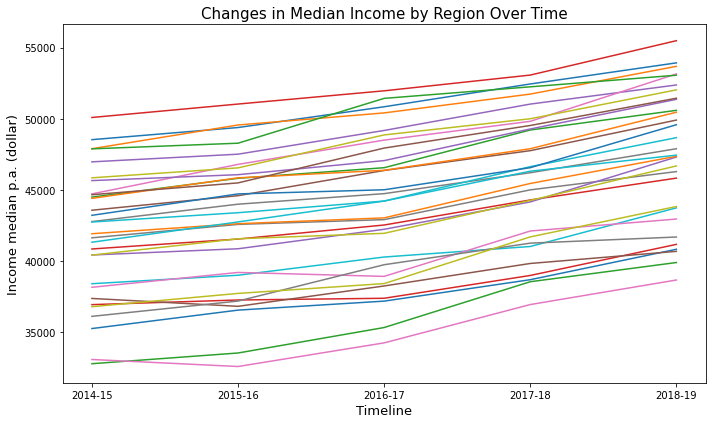

In [27]:
# choose 30 place to show the income changes
EXAMPLE_SIZE = 30
plt.figure(figsize=(10,6))
for i in range(EXAMPLE_SIZE):
    plt.plot(income_data.columns.str.slice(stop=7).to_list(), income_data.iloc[i,:].copy())
plt.title('Changes in Median Income by Region Over Time', fontsize = 15)
plt.xlabel('Timeline', fontsize = 13)
plt.ylabel('Income median p.a. (dollar)', fontsize = 13)
plt.tight_layout()
plt.savefig('../plots/income_history.png')
plt.show()

In [28]:
# extract the time steps
income_timestep = income_data.columns.to_list()

In [29]:
# use one instance as example to check r-square for the model
INDEX = 0
income_result_df = pd.DataFrame()
income_value = income_data.iloc[INDEX, :].to_list()
income_train_year = [i for i in range(14, 17)]
income_predict_year = [i for i in range(17, 19)]

# set the first 3 years data as train data 
income_final_df = linear_model_function(income_train_year, income_value[:3], income_predict_year)
result = [income_result_df, income_final_df.transpose()]
income_result_df = pd.concat(result)


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     43.56
Date:                Sat, 15 Oct 2022   Prob (F-statistic):             0.0957
Time:                        20:00:37   Log-Likelihood:                -19.147
No. Observations:                   3   AIC:                             42.29
Df Residuals:                       1   BIC:                             40.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.224e+04   2632.278     12.248      0.0

In [ ]:
# train all historical income and predict future income for each region
income_result_df = pd.DataFrame()
for index in range(len(income_data)):
    income_value = income_data.iloc[index, :].to_list()
    income_train_year = [i for i in range(14, 19)]
    income_predict_year = [i for i in range(19, 28)]

    # fit the linear model
    income_final_df = linear_model_function(income_train_year, income_value, income_predict_year)
    result = [income_result_df, income_final_df.transpose()]
    income_result_df = pd.concat(result)

In [31]:
# add prediction time steps
for i in range(19, 28):
    income_timestep.append(f'20{i}-{i+1}_median_income')

In [32]:
# adjust the total output and store as csv
income_result_df = income_result_df.loc['Y', :].copy()
income_result_df.columns = income_timestep
income_result_df = income_result_df.reset_index(drop=True)
income_result_df['SA2_Code'] = sa2['SA2_Code']
income_result_df['SA2_name'] = sa2['SA2_name']
income_result_df.to_csv('../data/curated/predict_income_ols.csv', index=False)


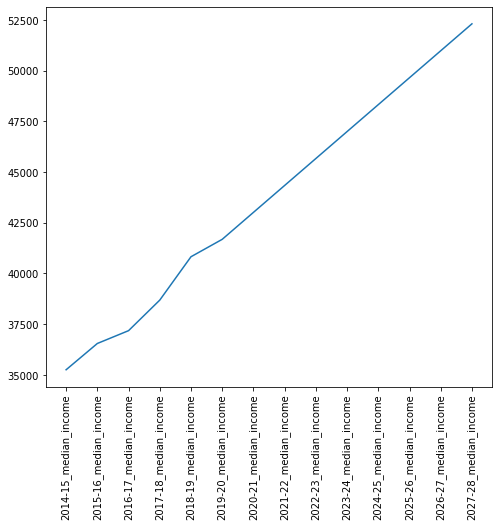

In [33]:
# plot one instance and show the result
plt.figure(figsize=(8,7))
plt.plot(income_result_df.iloc[10, :14])
plt.xticks(rotation=90)
plt.show()

### Predict house price

In [34]:
# read the house price data and extract the place feature
house_price_data = pd.read_csv('../data/curated/house_price.csv')
locality = house_price_data['locality']

In [35]:
# fill the missing value as 0 in dataset to keep the authenticity of data
house_price_data = house_price_data.replace('', 0)
house_price_data = house_price_data.replace('-', 0)
house_price_data =  house_price_data.replace(np.nan, 0)

# extract the data for modelling
price_median = ['2010 Median', '2011 Median', '2012 Median', '2013 Median',
                '2014 Median', '2015 Median', '2016 Median', '2017 Median',
                '2018 Median', '2019 Median', '2020 Median']
train_median_price = house_price_data[price_median]

#### auto reg

use example to check the performance of model

In [36]:
example_house = train_median_price.iloc[10,:].astype('int').copy()

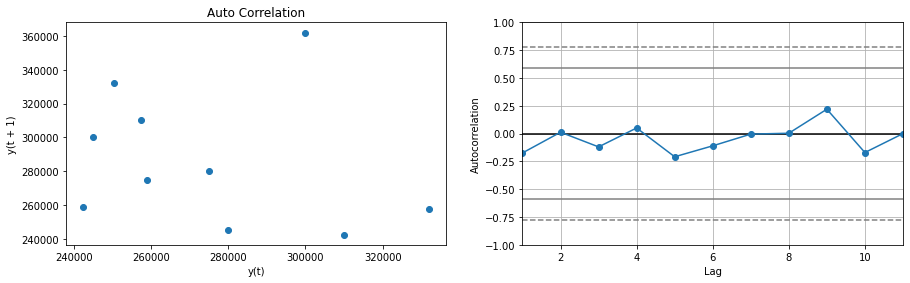

In [37]:
# plot auto correlation
plt.figure(figsize=(15,9))
plt.subplot(221)
lag_plot(example_house)
plt.title('Auto Correlation')

# plot the figure to select lag value
plt.subplot(222)
autocorrelation_plot(example_house, marker='o')
plt.show()

predicted=270603.629161, expected=280000.000000
predicted=268869.370352, expected=245000.000000
predicted=281009.182012, expected=300000.000000
predicted=261932.335118, expected=362000.000000
Test RMSE: 52517.205


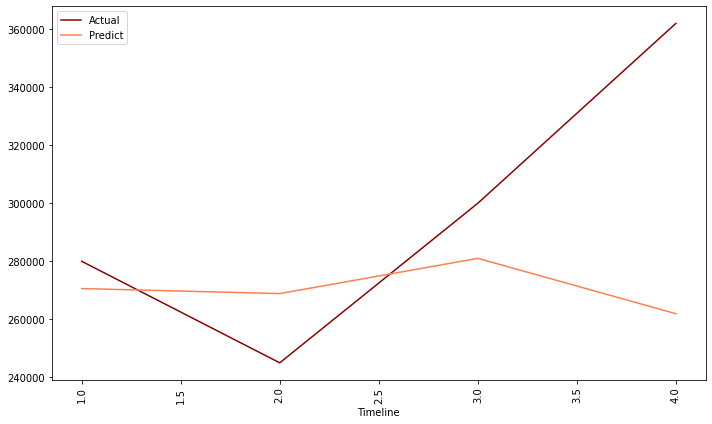

In [38]:
# use example to fit the model and check model performance
lag_value = 1
test_size = 4
example_result = autoregression_model_pipeline(example_house, test_size, test_size, lag_value)

In [39]:
# generate the column name
house_col = train_median_price.columns.to_list()
house_pred_col = ['2021 Median',
                    '2022 Median',
                    '2023 Median',
                    '2024 Median',
                    '2025 Median',
                    '2026 Median',
                    '2027 Median']
house_col.extend(house_pred_col)

In [40]:
# train the whole dataset and predict 7 year result
HOUSE_PREDICT_YEAR = 7
house_result_df = pd.DataFrame()
lag_value = 2

index = 0
while index < len(train_median_price):

    # fit the model
    predictions = autoregression_model_pipeline(train_median_price.iloc[index,:].astype('int'), 0, HOUSE_PREDICT_YEAR, lag_value)

    # append each prediction
    total_value = train_median_price.iloc[index,:].astype('int').copy().to_list()
    total_value.extend(predictions)

    # change the dimension and save to dataframe
    temp = pd.DataFrame()
    temp = temp.append(total_value).transpose()
    house_result_df = house_result_df.append(temp).reset_index(drop=True)
    index += 1

# set the column name and add locality column
house_result_df.columns = house_col
house_result_df['locality'] = locality

# save the population data
house_result_df.to_csv('../data/curated/predict_house_price_AutoReg.csv', index=False)

#### ols

In [ ]:
# predict house median price by ols
predict_median_price = pd.DataFrame()
for index in range(len(train_median_price)):
    median_price_value = train_median_price.iloc[index, :].astype('float').copy().to_list()
    median_price_train_year = [i for i in range(10, 21)]
    median_price_predict_year = [i for i in range(21, 28)]

    # fit the model
    median_final_df = linear_model_function(median_price_train_year, median_price_value, median_price_predict_year)
    result = [predict_median_price, median_final_df.transpose()]
    predict_median_price = pd.concat(result)

In [42]:
# form the timeline for both historical data and predictions
median_price_timeline = []
for i in range(10, 28):
    median_price_timeline.append(f'20{i}_median')

In [43]:
# adjust the final output and save the data
predict_median_price = predict_median_price.loc['Y', :].copy()
predict_median_price.columns = median_price_timeline
predict_median_price['locality'] = house_price_data['locality'].tolist()
predict_median_price.to_csv('../data/curated/predict_house_price_median.csv', index=False)

### Predict rental median

In [44]:
# read the history rental median data
rental_median_data = pd.read_csv('../data/curated/rental_median.csv')

# extract the total median data and fill missing data as 0
column_names = []
for i in rental_median_data.columns:
    if 'total' in i and 'b' not in i:
        column_names.append(i)
rental_data = rental_median_data[column_names]
rental_data = rental_data.replace('-', 0)

use example to check the performance of model

In [45]:
INDEX_RENTAL = 5
example_rental = rental_data.loc[INDEX_RENTAL]

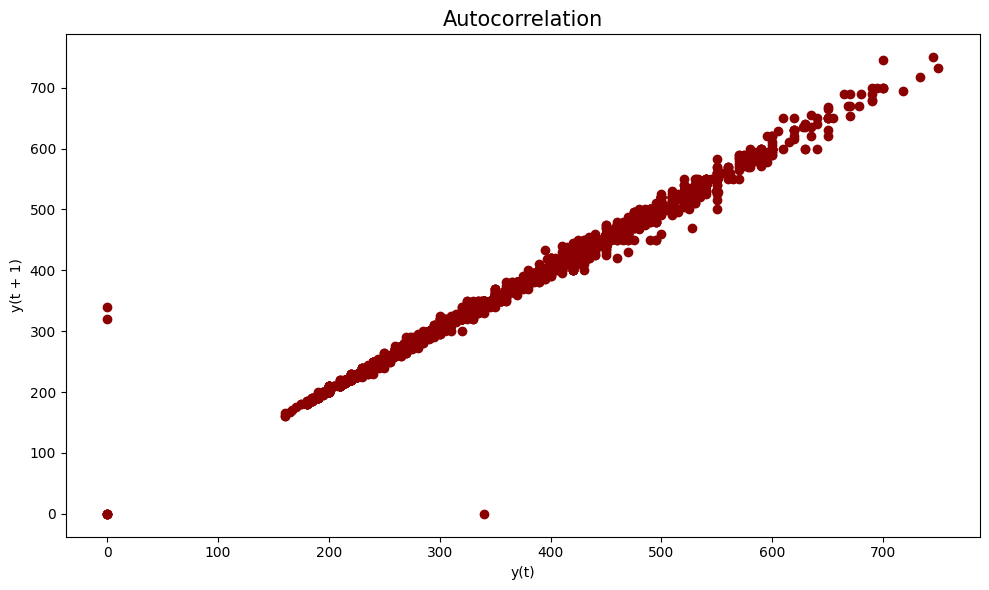

In [46]:
# use frist 30 places data as example to observe the autocorrelation
plt.style.use('default')
fig, ax = plt.subplots(figsize = (10,6))
for i in range(EXAMPLE_SIZE):
    lag_plot(rental_data.loc[i].astype('int'), c='darkred', ax =ax)
plt.title('Autocorrelation', fontsize=15)
plt.tight_layout()
plt.savefig('../plots/t_t+1_corr.png')
plt.show()


the auto-correlation shows a strong correlation between current time step and next time step

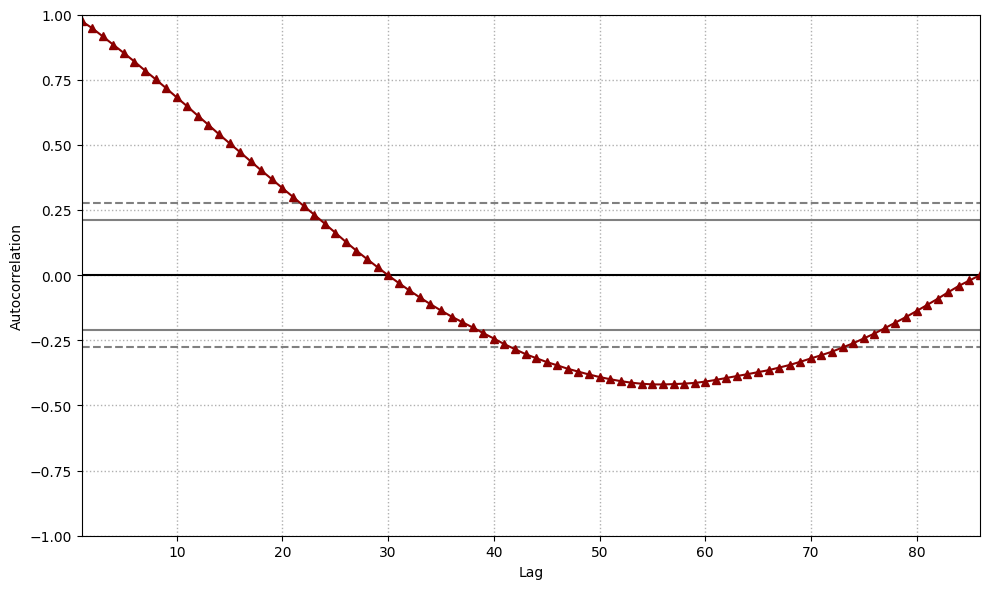

In [47]:
# plot the autocorrelation plot and select the lag value
fig, ax = plt.subplots(figsize = (10,6))
autocorrelation_plot(example_rental.astype('int'), c='darkred', marker='^')
ax.grid(linestyle=':', linewidth=1)
plt.tight_layout()
plt.savefig('../plots/autocorrelation.png')
plt.show()


predicted=402.897943, expected=410.000000
predicted=412.780682, expected=410.000000
predicted=413.042212, expected=418.000000
predicted=417.275867, expected=420.000000
predicted=421.901540, expected=420.000000
predicted=419.952368, expected=420.000000
predicted=422.784248, expected=430.000000
predicted=433.697731, expected=430.000000
predicted=437.246716, expected=440.000000
predicted=440.885993, expected=440.000000
predicted=439.962090, expected=450.000000
predicted=446.479746, expected=450.000000
predicted=455.762116, expected=450.000000
predicted=452.987719, expected=450.000000
predicted=453.436864, expected=450.000000
predicted=449.952604, expected=450.000000
predicted=447.326155, expected=450.000000
predicted=450.459492, expected=440.000000
predicted=441.721357, expected=425.000000
predicted=426.374299, expected=425.000000
Test RMSE: 6.054


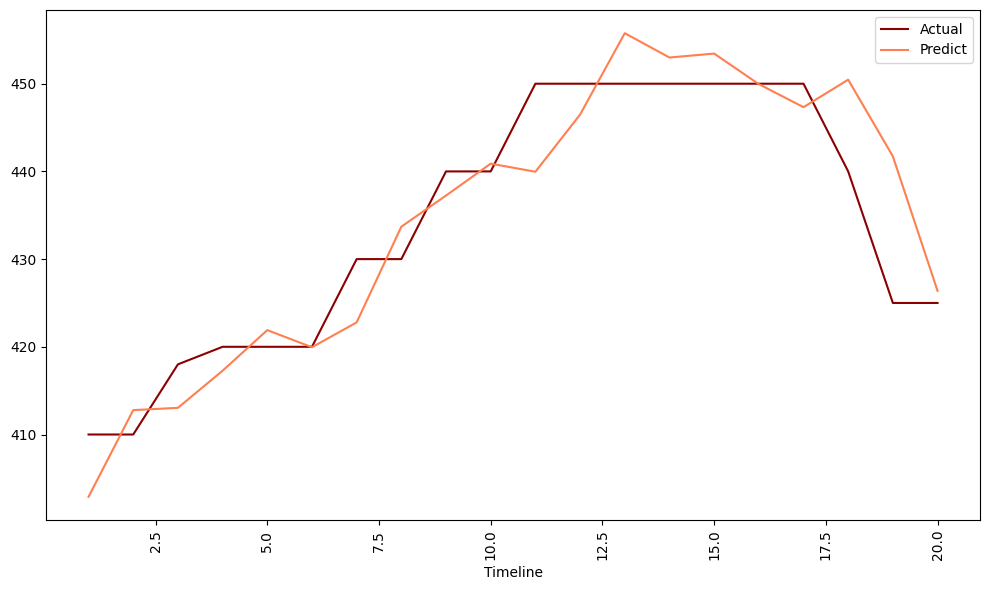

In [48]:
# use one instance as example to check the RMSE for model performance
lag_value = 23
predict_size = 20
example_result = autoregression_model_pipeline(example_rental.astype('float'), predict_size, predict_size, lag_value)

In [49]:
# generate the column name for rental timeline
rental_pred_name = ['Sep_2021', 'Dec_2021',
                    'Mar_2022', 'Jun_2022', 'Sep_2022', 'Dec_2022',
                    'Mar_2023', 'Jun_2023', 'Sep_2023', 'Dec_2023',
                    'Mar_2024', 'Jun_2024', 'Sep_2024', 'Dec_2024',
                    'Mar_2025', 'Jun_2025', 'Sep_2025', 'Dec_2025',
                    'Mar_2026', 'Jun_2026', 'Sep_2026', 'Dec_2026',
                    'Mar_2027', 'Jun_2027', 'Sep_2027', 'Dec_2027']
rental_col = rental_data.columns.str.slice(start=13).to_list()
rental_col.extend(rental_pred_name)

In [50]:
# train the whole dataset and predict 26 quarter result
PREDICT_LEN = 26
result_df = pd.DataFrame()
lag_value = 23

index = 0
while index < len(rental_data):

    # fit the model
    predictions = autoregression_model_pipeline(rental_data.iloc[index,:].astype('float'), 0, PREDICT_LEN, lag_value)

    # append each prediction
    total_value = rental_data.astype('float').iloc[index,:].to_list()
    total_value.extend(predictions)

    # change the dimension and save to dataframe
    temp = pd.DataFrame()
    temp = temp.append(total_value).transpose()
    result_df = result_df.append(temp).reset_index(drop=True)
    index += 1

# set the column name and add suburb column
result_df.columns = rental_col
result_df['suburb'] = rental_median_data['suburb']

# save the rental median data
result_df.to_csv('../data/curated/predict_rental_AutoReg.csv', index=False)


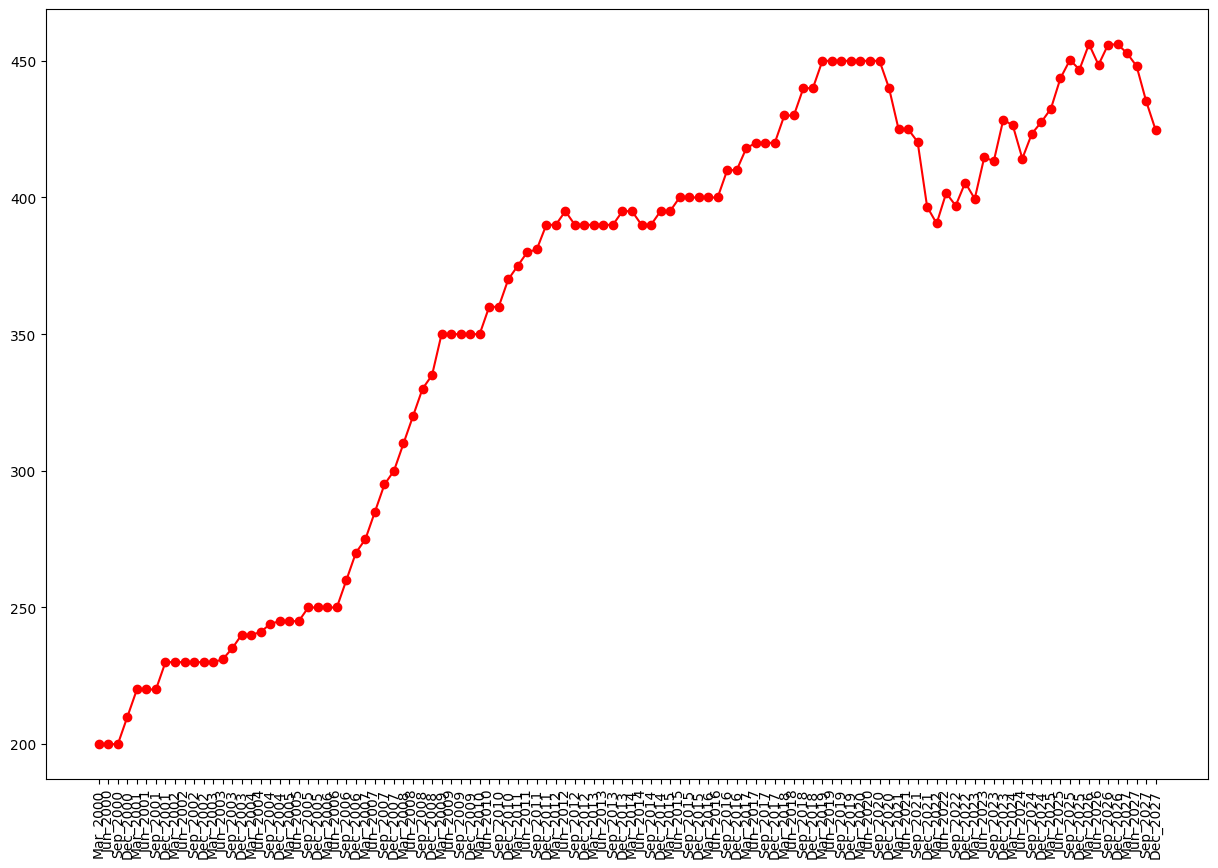

In [53]:
# plot an instance to show the result
plt.figure(figsize=(15,10))
plt.plot(rental_col, result_df.iloc[INDEX_RENTAL,:-1], color='red', marker='o')
plt.xticks(rotation=90)
plt.show()

### Using Randomforest model to predict property rent

##### build model dataframe 

In [17]:
# read in property data
property_data = pd.read_csv('../data/curated/data.csv')
property_data.shape

(13455, 119)

In [18]:
# have a look of property data
property_data.head()

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,Flagstaff Railway Station (Melbourne City),41.4,282.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,3000,Studio,1,0,0,1,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,Parliament Railway Station (Melbourne City),117.8,762.1
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,Melbourne Central Railway Station (Melbourne C...,69.9,515.3
3,918/422 Collins St Melbourne VIC 3000,600,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,Flagstaff Railway Station (Melbourne City),138.9,1103.0
4,602/118 Franklin Street Melbourne VIC 3000,330,6,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,Melbourne Central Railway Station (Melbourne C...,62.6,533.6


In [19]:
# drop the names (string)
property_data = property_data.drop(columns=['postcode'])
property_data = property_data.drop(columns=['cloest_train_station'])
property_data = property_data.drop(columns=['cloest_TRAIN_STATION'])
property_data = property_data.drop(columns=['address'])
property_data = property_data.drop(columns=['coordinates'])

# convert types into numeric
property_data = property_data.replace(to_replace=r'Apartment \/ Unit \/ Flat \/ Penhouse', value=1, regex=True)
property_data = property_data.replace(to_replace=r'Studio', value=2, regex=True)
property_data = property_data.replace(to_replace=r'Townhouse', value=3, regex=True)
property_data = property_data.replace(to_replace=r'House', value=4, regex=True)
property_data['type'] = property_data['type'].astype('int')

# check dataset
property_data

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_GOLF COURSE,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,400,14,MELBOURNE,1,0,0,0,1,1,0,...,6222.441683,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0
1,350,11,MELBOURNE,2,1,0,0,1,1,0,...,7106.445738,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1
2,330,9,MELBOURNE,1,0,0,0,1,1,0,...,6639.250058,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3
3,600,9,MELBOURNE,1,0,0,0,2,1,0,...,6940.305653,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0
4,330,6,MELBOURNE,1,0,0,0,1,1,0,...,6243.470050,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,INVERLOCH,4,0,0,0,2,1,1,...,119551.399390,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0
13451,550,1,INVERLOCH,4,1,0,0,4,2,0,...,119045.645193,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0
13452,440,1,INVERLOCH,4,0,0,0,2,1,0,...,119645.375833,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0
13453,580,1,INVERLOCH,4,0,0,0,3,2,1,...,119544.858478,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0


In [20]:
# save a copy of property data
relationship_data = property_data.copy()

# get all the columns in property data
cols = relationship_data.columns.tolist()
cols

['rent_weekly',
 'floor',
 'suburb',
 'type',
 'furnitured',
 'pool',
 'gym',
 'num_bed',
 'num_bath',
 'num_car_park',
 'SECONDARY SCHOOL',
 'PRIMARY AND SECONDARY SCHOOL',
 'PRIMARY SCHOOL',
 'SHOPPING CENTRE',
 'PARK',
 'KINDERGARTEN',
 'POST OFFICE',
 'SPECIAL SCHOOL',
 'CHILD CARE',
 'BAR',
 'SPORTS COMPLEX',
 'EDUCATION COMPLEX',
 'CEMETERY',
 'LIBRARY',
 'UNIVERSITY',
 'GENERAL HOSPITAL',
 'POLICE STATION',
 'FURTHER EDUCATION',
 'PLAYGROUND',
 'PLANTATION',
 'WINERY',
 'FARM',
 'VINEYARD',
 'TENNIS COURT',
 'BAY',
 'PIER',
 'SWIMMING POOL',
 'ART GALLERY',
 'HARBOUR',
 'COMMUNITY HEALTH CENTRE',
 'MARKET',
 'PRISON',
 'BOTANIC GARDENS',
 'SPECIALISED HOSPITAL',
 'BANK',
 'AGED CARE',
 'SURFING SPOT',
 'COAST',
 'GOLF COURSE',
 'HELIPORT',
 'AIRPORT',
 'IRON ORE PROCESSOR',
 'MILL/TIMBER OPERATIONS',
 'BEACH',
 'TRAIN STATION',
 'TRAM STATION',
 'BUS',
 'Education',
 'Commercial',
 'Environment',
 'Medication',
 'Secrity',
 'Industrial',
 'Prison',
 'Transportation',
 'cloest_SE

In [21]:
# check dataframe after convert suburb
relationship_data = convert_suburb(relationship_data)
relationship_data.head()

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_GOLF COURSE,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,400,14,1,1,0,0,0,1,1,0,...,6222.441683,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0
1,350,11,1,2,1,0,0,1,1,0,...,7106.445738,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1
2,330,9,1,1,0,0,0,1,1,0,...,6639.250058,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3
3,600,9,1,1,0,0,0,2,1,0,...,6940.305653,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0
4,330,6,1,1,0,0,0,1,1,0,...,6243.470050,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6


In [22]:
# define internal feature name
internal_names = ['rent_weekly',
                    'floor',
                    'suburb',
                    'type',
                    'furnitured',
                    'pool',
                    'gym',
                    'num_bed',
                    'num_bath',
                    'num_car_park']

In [23]:
# read in predicted rental median price
predicted_rental_median_data = pd.read_csv('../data/curated/predict_rental_AutoReg.csv')
rental_median_data = predicted_rental_median_data.copy()
predicted_rental_median_data

,Mar_2000,Jun_2000,Sep_2000,Dec_2000,Mar_2001,Jun_2001,Sep_2001,Dec_2001,Mar_2002,Jun_2002,...,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027,suburb
0,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,235.0,230.0,...,470.788260,476.138841,489.589854,506.609227,506.040747,507.802128,495.320207,466.718926,435.693246,ARMADALE
1,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,290.0,290.0,...,581.299437,583.971306,586.838628,590.900784,590.016575,586.228050,593.272160,590.145434,586.103787,CARLTON NORTH
2,0.0,340.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0,340.0,...,572.823743,582.945931,573.161336,577.137157,552.734918,523.166187,462.130288,432.159780,402.001520,DOCKLANDS
3,265.0,268.0,280.0,273.0,290.0,295.0,300.0,320.0,320.0,320.0,...,507.449399,509.092467,537.953688,565.610370,559.126826,519.042227,497.681810,470.812384,451.207502,EAST MELBOURNE
4,180.0,180.0,180.0,185.0,185.0,190.0,195.0,195.0,200.0,200.0,...,427.399892,428.356845,430.717732,427.402418,422.204277,425.744266,414.487443,408.002477,385.846916,ST KILDA EAST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,185.0,185.0,190.0,200.0,200.0,200.0,210.0,210.0,215.0,220.0,...,429.034421,422.460956,418.307158,410.400120,412.738174,412.722239,411.692067,416.639426,412.401402,AVONDALE HEIGHTS
137,170.0,175.0,180.0,180.0,180.0,185.0,190.0,190.0,200.0,200.0,...,487.763098,470.511558,503.251257,510.860759,508.790797,498.551593,500.793220,499.192457,494.203249,NEWPORT
138,170.0,175.0,180.0,180.0,180.0,185.0,190.0,190.0,200.0,200.0,...,487.763098,470.511558,503.251257,510.860759,508.790797,498.551593,500.793220,499.192457,494.203249,SPOTSWOOD
139,150.0,155.0,155.0,160.0,160.0,160.0,160.0,160.0,165.0,165.0,...,354.599367,348.092233,361.804702,364.505011,363.233188,354.453939,359.692473,353.072851,346.029958,ST ALBANS


In [24]:
# pick up the predict rental median
predicted_median_list = predicted_rental_median_data.columns.tolist()[90:]

predicted_rental_median_data = predicted_rental_median_data[predicted_median_list]

# rename the predicted rental median and make them easy to see
name = [i[-8:] for i in predicted_rental_median_data.columns]
predicted_rental_median_data.columns = name

predicted_rental_median_data

,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,Sep_2024,Dec_2024,...,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027,suburb
0,435.798057,415.142590,401.506473,367.276539,400.077237,410.809804,452.820839,500.548633,496.403577,512.828629,...,470.788260,476.138841,489.589854,506.609227,506.040747,507.802128,495.320207,466.718926,435.693246,ARMADALE
1,538.928921,529.361956,540.392340,511.458428,529.182111,535.867575,550.756115,542.615450,561.839854,556.051452,...,581.299437,583.971306,586.838628,590.900784,590.016575,586.228050,593.272160,590.145434,586.103787,CARLTON NORTH
2,525.566336,554.118146,518.505844,517.071345,540.913287,522.920856,472.687322,525.966327,557.508975,556.280447,...,572.823743,582.945931,573.161336,577.137157,552.734918,523.166187,462.130288,432.159780,402.001520,DOCKLANDS
3,472.810787,474.727424,463.297494,460.443781,473.168199,493.125239,503.083327,492.963574,498.609383,476.063390,...,507.449399,509.092467,537.953688,565.610370,559.126826,519.042227,497.681810,470.812384,451.207502,EAST MELBOURNE
4,383.734143,389.843007,387.469527,389.011787,393.980157,408.675237,396.675572,398.778214,387.106626,403.603669,...,427.399892,428.356845,430.717732,427.402418,422.204277,425.744266,414.487443,408.002477,385.846916,ST KILDA EAST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,367.658491,375.351703,385.625193,401.066953,401.242866,397.491675,388.671260,398.468198,396.174235,412.054090,...,429.034421,422.460956,418.307158,410.400120,412.738174,412.722239,411.692067,416.639426,412.401402,AVONDALE HEIGHTS
137,448.437301,455.129110,454.973414,461.288410,454.995795,446.878066,464.025609,454.473636,478.027041,465.103921,...,487.763098,470.511558,503.251257,510.860759,508.790797,498.551593,500.793220,499.192457,494.203249,NEWPORT
138,448.437301,455.129110,454.973414,461.288410,454.995795,446.878066,464.025609,454.473636,478.027041,465.103921,...,487.763098,470.511558,503.251257,510.860759,508.790797,498.551593,500.793220,499.192457,494.203249,SPOTSWOOD
139,310.963567,315.703079,326.524021,327.504067,320.818857,325.390782,337.106385,343.462167,350.087483,355.920324,...,354.599367,348.092233,361.804702,364.505011,363.233188,354.453939,359.692473,353.072851,346.029958,ST ALBANS


In [25]:
# pickup the current rental median
add_into_moedel_median_data = pd.DataFrame()
add_into_moedel_median_data['suburb'] = predicted_rental_median_data['suburb']
add_into_moedel_median_data['Sep_2022'] = predicted_rental_median_data['Sep_2022']
add_into_moedel_median_data.head()

,suburb,Sep_2022
0,ARMADALE,435.798057
1,CARLTON NORTH,538.928921
2,DOCKLANDS,525.566336
3,EAST MELBOURNE,472.810787
4,ST KILDA EAST,383.734143


In [26]:
# combine the current rantal median and the property data
property_data_copy = property_data.copy()
model_dataset = pd.merge(property_data_copy,add_into_moedel_median_data, \
                                on='suburb', how='left').fillna(0)
# clean features and convert string to numeric 
model_dataset = convert_suburb(model_dataset)
model_dataset

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,Sep_2022
0,400,14,1,1,0,0,0,1,1,0,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0,426.575597
1,350,11,1,2,1,0,0,1,1,0,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1,426.575597
2,330,9,1,1,0,0,0,1,1,0,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3,426.575597
3,600,9,1,1,0,0,0,2,1,0,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0,426.575597
4,330,6,1,1,0,0,0,1,1,0,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6,426.575597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,570,4,0,0,0,2,1,1,...,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0,0.000000
13451,550,1,570,4,1,0,0,4,2,0,...,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0,0.000000
13452,440,1,570,4,0,0,0,2,1,0,...,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0,0.000000
13453,580,1,570,4,0,0,0,3,2,1,...,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0,0.000000


In [27]:
# get column name for X
x_col_name = []
for i in model_dataset.columns:
    if i != 'rent_weekly':
        x_col_name.append(i)
x_col_name

['floor',
 'suburb',
 'type',
 'furnitured',
 'pool',
 'gym',
 'num_bed',
 'num_bath',
 'num_car_park',
 'SECONDARY SCHOOL',
 'PRIMARY AND SECONDARY SCHOOL',
 'PRIMARY SCHOOL',
 'SHOPPING CENTRE',
 'PARK',
 'KINDERGARTEN',
 'POST OFFICE',
 'SPECIAL SCHOOL',
 'CHILD CARE',
 'BAR',
 'SPORTS COMPLEX',
 'EDUCATION COMPLEX',
 'CEMETERY',
 'LIBRARY',
 'UNIVERSITY',
 'GENERAL HOSPITAL',
 'POLICE STATION',
 'FURTHER EDUCATION',
 'PLAYGROUND',
 'PLANTATION',
 'WINERY',
 'FARM',
 'VINEYARD',
 'TENNIS COURT',
 'BAY',
 'PIER',
 'SWIMMING POOL',
 'ART GALLERY',
 'HARBOUR',
 'COMMUNITY HEALTH CENTRE',
 'MARKET',
 'PRISON',
 'BOTANIC GARDENS',
 'SPECIALISED HOSPITAL',
 'BANK',
 'AGED CARE',
 'SURFING SPOT',
 'COAST',
 'GOLF COURSE',
 'HELIPORT',
 'AIRPORT',
 'IRON ORE PROCESSOR',
 'MILL/TIMBER OPERATIONS',
 'BEACH',
 'TRAIN STATION',
 'TRAM STATION',
 'BUS',
 'Education',
 'Commercial',
 'Environment',
 'Medication',
 'Secrity',
 'Industrial',
 'Prison',
 'Transportation',
 'cloest_SECONDARY SCHOOL',

In [28]:
# build train data
train_y = model_dataset['rent_weekly']
train_x = model_dataset[x_col_name]

##### Try Randomforest

In [29]:
# try random forest regressor
%time
rf = RandomForestRegressor(n_estimators = 400, max_features = 'sqrt', max_depth = 5, random_state = 50)
rf.fit(train_x, train_y)
pred = rf.predict(train_x)
mse = mean_squared_error(train_y, pred)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
The mse is :  13511.214749368415
The rmse is :  116.2377509648583


##### Try ols

In [30]:
# build linear model
ols_data = relationship_data.copy()
ols_data

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_GOLF COURSE,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,400,14,1,1,0,0,0,1,1,0,...,6222.441683,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0
1,350,11,1,2,1,0,0,1,1,0,...,7106.445738,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1
2,330,9,1,1,0,0,0,1,1,0,...,6639.250058,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3
3,600,9,1,1,0,0,0,2,1,0,...,6940.305653,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0
4,330,6,1,1,0,0,0,1,1,0,...,6243.470050,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,570,4,0,0,0,2,1,1,...,119551.399390,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0
13451,550,1,570,4,1,0,0,4,2,0,...,119045.645193,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0
13452,440,1,570,4,0,0,0,2,1,0,...,119645.375833,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0
13453,580,1,570,4,0,0,0,3,2,1,...,119544.858478,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0


In [31]:
# check columns
ols_data.columns

Index(['rent_weekly', 'floor', 'suburb', 'type', 'furnitured', 'pool', 'gym',
       'num_bed', 'num_bath', 'num_car_park',
       ...
       'cloest_GOLF COURSE', 'cloest_HELIPORT', 'cloest_AIRPORT',
       'cloest_IRON ORE PROCESSOR', 'cloest_MILL/TIMBER OPERATIONS',
       'cloest_BEACH', 'cloest_TRAM STATION', 'cloest_BUS',
       'cloest_TRAIN_STATION_duration', 'cloest_TRAIN_STATION_distance'],
      dtype='object', length=114)

In [32]:
# check ols summary
olsmod = sm.OLS(train_y, train_x)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:            rent_weekly   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     16.69
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          2.95e-264
Time:                        20:23:51   Log-Likelihood:                -83375.
No. Observations:               13455   AIC:                         1.670e+05
Df Residuals:                   13354   BIC:                         1.677e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [33]:
# use ols predict rental price
pred_ols = olsres.predict(train_x)
mse = mean_squared_error(train_y, pred_ols)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

The mse is :  14119.08952107736
The rmse is :  118.8237750665975


##### Keep using Randomforest, only merge rental median data with property data

In [34]:
# get years need to be predict
predict_year_list = predicted_rental_median_data.columns[:-1].tolist()
predict_year_list

['Sep_2022',
 'Dec_2022',
 'Mar_2023',
 'Jun_2023',
 'Sep_2023',
 'Dec_2023',
 'Mar_2024',
 'Jun_2024',
 'Sep_2024',
 'Dec_2024',
 'Mar_2025',
 'Jun_2025',
 'Sep_2025',
 'Dec_2025',
 'Mar_2026',
 'Jun_2026',
 'Sep_2026',
 'Dec_2026',
 'Mar_2027',
 'Jun_2027',
 'Sep_2027',
 'Dec_2027']

In [35]:
# have a look of model dataset 
model_dataset

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,Sep_2022
0,400,14,1,1,0,0,0,1,1,0,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0,426.575597
1,350,11,1,2,1,0,0,1,1,0,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1,426.575597
2,330,9,1,1,0,0,0,1,1,0,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3,426.575597
3,600,9,1,1,0,0,0,2,1,0,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0,426.575597
4,330,6,1,1,0,0,0,1,1,0,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6,426.575597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,570,4,0,0,0,2,1,1,...,114739.370455,19432.079609,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0,0.000000
13451,550,1,570,4,1,0,0,4,2,0,...,114185.004327,21263.394445,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0,0.000000
13452,440,1,570,4,0,0,0,2,1,0,...,114860.049711,18411.587767,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0,0.000000
13453,580,1,570,4,0,0,0,3,2,1,...,114744.013670,18990.553488,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0,0.000000


In [36]:
# put rent price into list
save_original_rent_weekly = model_dataset['rent_weekly'].tolist()

In [37]:
# predict future years and four seasons
final_predict_year = 22

# ready to save the predict result
predict_result_df = pd.DataFrame()

# initialize count value
count = 1


for future_year in predict_year_list:

    # print years to check the loop
    print(future_year)

    # initialize predict dataset
    add_into_moedel_median_data = pd.DataFrame()
    add_into_moedel_median_data['suburb'] = predicted_rental_median_data['suburb']
    add_into_moedel_median_data[future_year] = predicted_rental_median_data[future_year]

    # merge datasets
    model_dataset = pd.merge(property_data_copy,add_into_moedel_median_data,\
                                            on='suburb', how='left').fillna(0)

    # convert suburbs into numeric for prediction
    model_dataset = convert_suburb(model_dataset)

    # rename the current year into loop year
    model_dataset = model_dataset.rename(columns={'Sep_2022':'loop_future_timeline'})

    # build train Y
    train_Y = pd.DataFrame()
    train_Y['rent_weekly'] = model_dataset['rent_weekly']

    # build train X
    train_X = pd.DataFrame()
    train_X = model_dataset.drop(columns = 'rent_weekly')

    # build randon forest regressor model 
    rf = RandomForestRegressor(n_estimators = 350, max_features = 'sqrt', max_depth = 50, random_state = 50)
    rf.fit(train_X, train_Y['rent_weekly'])

    # predict 
    pred = rf.predict(train_X)
    
    # put predict result in dataframe
    predict_result_df[future_year] = pred

    # update train Y and train X
    train_Y['rent_weekly'] = pred
    train_X['loop_future_timeline'] = predicted_rental_median_data[\
                                        predicted_rental_median_data.columns[count]]

    # if reach the end of predict year break loop
    if count == final_predict_year:
        break

# check the result of prediction
predict_result_df

Sep_2022
Dec_2022
Mar_2023
Jun_2023
Sep_2023
Dec_2023
Mar_2024
Jun_2024
Sep_2024
Dec_2024
Mar_2025
Jun_2025
Sep_2025
Dec_2025
Mar_2026
Jun_2026
Sep_2026
Dec_2026
Mar_2027
Jun_2027
Sep_2027
Dec_2027


,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,Sep_2024,Dec_2024,...,Sep_2025,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027
0,486.671429,483.857143,483.757143,487.057143,485.514286,483.314286,482.114286,487.800000,485.142857,483.400000,...,484.885714,480.714286,482.557143,486.442857,482.614286,484.957143,484.600000,485.514286,483.142857,484.557143
1,423.971429,425.385714,425.714286,423.385714,423.442857,421.414286,425.382857,422.100000,426.557143,427.342857,...,425.185714,424.028571,423.371429,423.157143,427.671429,425.642857,422.385714,424.185714,421.585714,425.085714
2,410.128571,410.985714,409.742857,409.357143,408.514286,409.385714,409.300000,410.371429,409.185714,411.042857,...,411.357143,409.642857,409.900000,410.614286,410.214286,411.625714,407.257143,410.171429,408.290476,407.514286
3,558.185714,558.571429,559.000000,557.571429,559.657143,560.000000,557.842857,555.542857,559.885714,562.400000,...,558.342857,560.885714,558.485714,560.314286,558.542857,558.885714,561.162112,559.914286,561.142857,558.471429
4,391.657143,391.300000,390.914286,391.900000,391.200000,392.828571,392.271429,389.142857,390.685714,389.600000,...,389.471429,390.857143,391.114286,391.785714,392.071429,393.385714,390.185714,390.200000,390.542857,389.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,526.042857,525.928571,528.785714,525.814286,526.757143,528.271429,525.914286,527.471429,522.671429,528.342857,...,526.771429,526.800000,528.357143,526.185714,528.542857,527.728571,526.357143,527.471429,526.242857,527.357143
13451,522.000000,520.214286,519.500000,521.428571,519.385714,521.500000,515.985714,518.200000,519.585714,522.357143,...,519.871429,519.385714,524.328571,523.457143,519.371429,520.228571,520.357143,517.042857,519.814286,520.700000
13452,446.285714,446.342857,447.214286,448.042857,448.700000,447.600000,446.828571,446.385714,448.142857,447.857143,...,442.600000,447.900000,446.828571,445.500000,445.314286,445.314286,446.185714,449.242857,447.471429,449.828571
13453,558.100000,559.485714,558.742857,558.428571,559.042857,557.985714,558.471429,558.514286,555.400000,558.757143,...,558.885714,557.171429,554.771429,557.114286,557.571429,556.900000,559.014286,556.385714,560.142857,560.614286


In [38]:
# initialize result dataframe
result_df = predict_result_df.copy()

# put original rent price in result dataframe
result_df.insert(0,'current_rent_weekly',property_data['rent_weekly'])

# show result dataframe
result_df

,current_rent_weekly,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,Sep_2024,...,Sep_2025,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027
0,400,486.671429,483.857143,483.757143,487.057143,485.514286,483.314286,482.114286,487.800000,485.142857,...,484.885714,480.714286,482.557143,486.442857,482.614286,484.957143,484.600000,485.514286,483.142857,484.557143
1,350,423.971429,425.385714,425.714286,423.385714,423.442857,421.414286,425.382857,422.100000,426.557143,...,425.185714,424.028571,423.371429,423.157143,427.671429,425.642857,422.385714,424.185714,421.585714,425.085714
2,330,410.128571,410.985714,409.742857,409.357143,408.514286,409.385714,409.300000,410.371429,409.185714,...,411.357143,409.642857,409.900000,410.614286,410.214286,411.625714,407.257143,410.171429,408.290476,407.514286
3,600,558.185714,558.571429,559.000000,557.571429,559.657143,560.000000,557.842857,555.542857,559.885714,...,558.342857,560.885714,558.485714,560.314286,558.542857,558.885714,561.162112,559.914286,561.142857,558.471429
4,330,391.657143,391.300000,390.914286,391.900000,391.200000,392.828571,392.271429,389.142857,390.685714,...,389.471429,390.857143,391.114286,391.785714,392.071429,393.385714,390.185714,390.200000,390.542857,389.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,526.042857,525.928571,528.785714,525.814286,526.757143,528.271429,525.914286,527.471429,522.671429,...,526.771429,526.800000,528.357143,526.185714,528.542857,527.728571,526.357143,527.471429,526.242857,527.357143
13451,550,522.000000,520.214286,519.500000,521.428571,519.385714,521.500000,515.985714,518.200000,519.585714,...,519.871429,519.385714,524.328571,523.457143,519.371429,520.228571,520.357143,517.042857,519.814286,520.700000
13452,440,446.285714,446.342857,447.214286,448.042857,448.700000,447.600000,446.828571,446.385714,448.142857,...,442.600000,447.900000,446.828571,445.500000,445.314286,445.314286,446.185714,449.242857,447.471429,449.828571
13453,580,558.100000,559.485714,558.742857,558.428571,559.042857,557.985714,558.471429,558.514286,555.400000,...,558.885714,557.171429,554.771429,557.114286,557.571429,556.900000,559.014286,556.385714,560.142857,560.614286


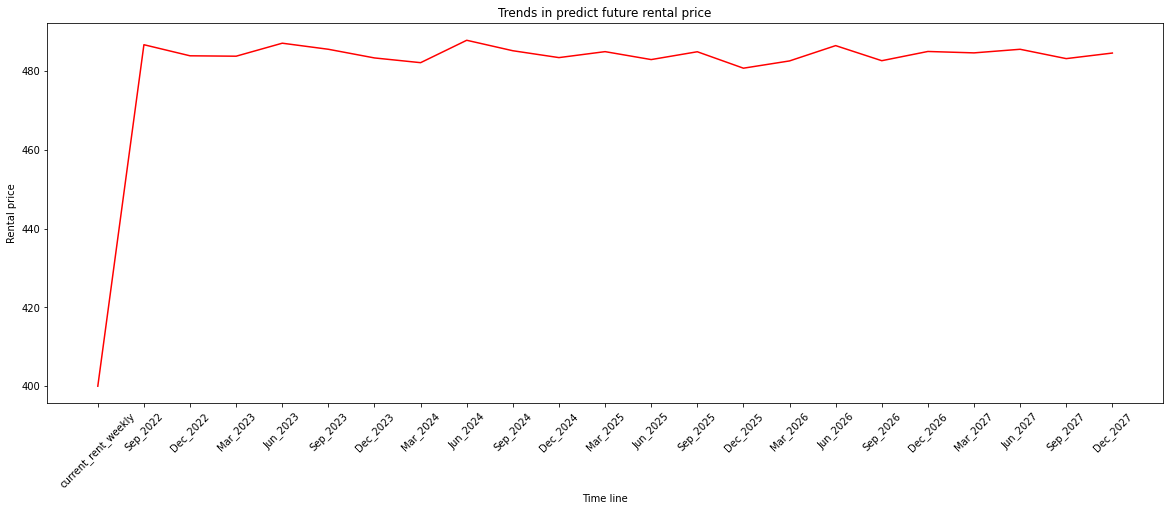

In [39]:
# plot the current rent price and predicted rent price in the future
# 1st property
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Rental price")
plt.xlabel("Time line")
plt.title("Trends in predict future rental price")
plt.plot(result_df.columns.tolist(),result_df.loc[0].tolist(), color = 'r')

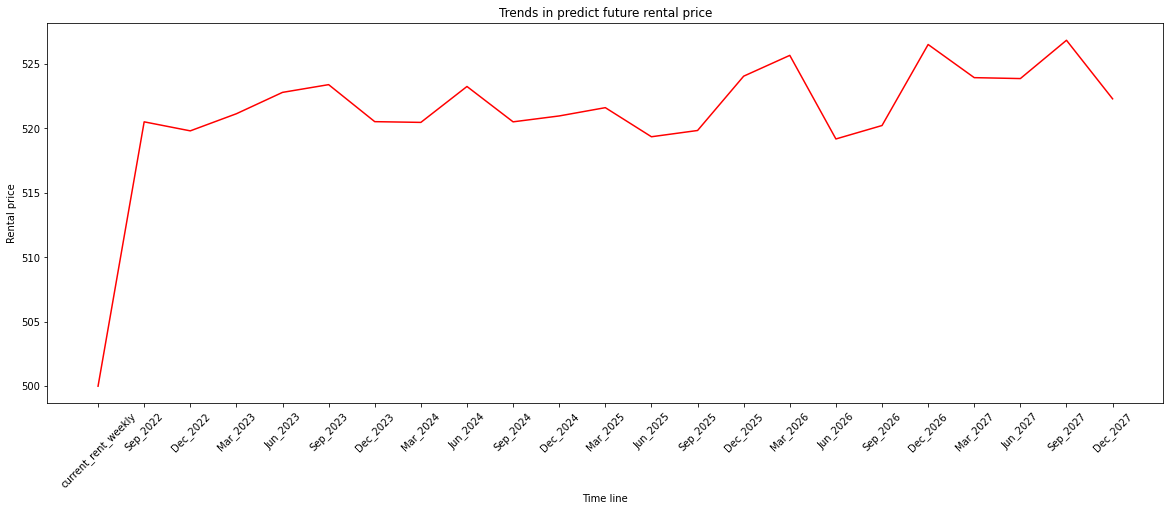

In [40]:
# plot the current rent price and predicted rent price in the future 
# another property
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Rental price")
plt.xlabel("Time line")
plt.title("Trends in predict future rental price")
plt.plot(result_df.columns.tolist(),result_df.loc[800].tolist(), color = 'r')

##### Check growth rate (rental mean)

In [41]:
# merge dataset
result_df.insert(0,'suburb',property_data['suburb'])

# groupby suburb and find mean
plot_df = result_df.copy()
all_col = plot_df.columns.drop('suburb').to_list()

# calculate mean rent price for each suburb
suburb_plot_df = plot_df.groupby('suburb').agg('mean')[all_col].reset_index()
suburb_plot_df

,suburb,current_rent_weekly,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,...,Sep_2025,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027
0,ABBOTSFORD,571.875000,572.760641,571.618537,572.773734,572.614998,572.563668,573.415014,572.440895,573.234927,...,572.037252,572.880621,572.056939,573.021318,572.666772,572.493371,572.866840,572.247835,572.531668,573.060823
1,ABERFELDIE,490.454545,492.684935,492.891905,491.663074,493.012771,492.439784,492.997792,493.123874,494.741277,...,494.724134,493.607143,492.743874,494.875844,492.411558,491.266883,494.701515,492.765974,491.381948,490.662684
2,ADAMS ESTATE,470.833333,471.516667,469.447976,470.250952,469.035714,469.241429,471.396190,469.209524,469.465714,...,470.440476,469.609524,469.704762,471.661905,470.666667,470.607143,469.800000,467.990476,467.814286,469.387619
3,ADDINGTON,388.750000,387.843198,389.565060,388.637679,387.670422,388.373755,387.573155,387.357619,386.074821,...,387.192456,388.451872,388.489877,386.055432,386.890554,385.508257,387.456300,387.918222,387.334378,387.620466
4,ADELAIDE LEAD,380.000000,379.132653,376.945986,369.404082,378.450000,377.211429,373.504082,375.446939,373.118367,...,369.157143,373.318367,376.269955,372.341701,374.018367,376.589796,377.132653,373.765193,371.561224,377.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,YARRAGON,420.000000,437.742857,435.357143,434.871429,438.157143,436.742857,435.585714,444.042857,437.328571,...,437.471429,442.285714,439.900000,440.842857,442.857143,442.090476,440.885714,433.885714,435.538095,442.580952
566,YARRAM,585.000000,563.868571,563.214286,566.042857,570.028571,560.842857,567.685714,558.688571,561.425714,...,563.814286,562.925714,564.000000,570.700000,560.900000,563.285714,566.754286,561.417143,561.271429,563.228571
567,YARRAVILLE,437.907692,441.186828,441.594836,441.636184,440.587525,441.746558,440.790983,441.646499,440.692456,...,442.148096,441.121668,441.540272,441.277855,441.195803,441.260419,441.874748,441.521534,441.323525,441.362118
568,YARRAWONGA,386.562500,382.879107,383.916429,383.396607,382.543750,382.853571,382.021429,383.620536,383.485536,...,382.333036,382.707857,382.449464,382.891964,383.177004,383.818036,383.306964,382.742679,383.391786,382.921250


In [42]:
# calculate growth rate
growth_rate_df = pd.DataFrame()

# get start year and end year
now_rent = suburb_plot_df['current_rent_weekly']
end_rent = suburb_plot_df['Dec_2027']

# calculate growth rate and use % as unit
growth_rate_df['suburb'] = suburb_plot_df['suburb']
growth_rate_df['growth_rate_mean (%)'] = ((end_rent-now_rent)/now_rent)*100

# descending the dataframe according to growth rate
growth_rate_df.sort_values('growth_rate_mean (%)',inplace=True, ascending=False)

# show top 20
growth_rate_df.head(20)

,suburb,growth_rate_mean (%)
46,BAMAWM EXTENSION,63.385281
527,TORRUMBARRY,43.011583
199,DONALD,41.014286
255,GILBERTON,39.552814
512,TANGAMBALANGA,36.750000
510,TALLAROOK,32.728571
433,OUYEN,31.333333
562,WURRUK,28.439560
13,ALLAMBEE RESERVE,26.484729
499,STRATFORD,25.742160


##### Check growth rate (rental mean)

In [43]:
# groupby suburb and calculate median for each suburb
suburb_plot_df = plot_df.groupby('suburb').agg('median')[all_col].reset_index()
suburb_plot_df

,suburb,current_rent_weekly,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,...,Sep_2025,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027
0,ABBOTSFORD,540.0,544.393095,544.577449,543.922211,542.342619,545.019830,546.364048,543.310068,544.826905,...,542.421190,545.023639,545.779524,543.461190,544.065476,544.295068,544.623163,545.011020,546.187211,547.699592
1,ABERFELDIE,475.0,463.290476,463.840714,468.087381,466.079524,466.493810,466.019048,464.719524,464.371667,...,467.304762,464.762381,464.618095,461.596429,464.161905,464.881667,463.125714,463.405714,465.883333,461.576190
2,ADAMS ESTATE,465.0,464.135714,462.000000,462.850000,462.500000,463.000000,464.928571,461.800000,461.142857,...,461.264286,460.842857,461.514286,464.085714,462.392857,463.371429,460.700000,459.657143,460.650000,462.164286
3,ADDINGTON,372.5,378.376786,381.734881,379.833690,378.390218,379.342747,378.125357,378.339643,376.121071,...,377.067619,378.668554,378.581508,376.293095,377.132537,375.620506,376.986310,377.315794,377.154145,378.107996
4,ADELAIDE LEAD,380.0,379.132653,376.945986,369.404082,378.450000,377.211429,373.504082,375.446939,373.118367,...,369.157143,373.318367,376.269955,372.341701,374.018367,376.589796,377.132653,373.765193,371.561224,377.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,YARRAGON,420.0,437.742857,435.357143,434.871429,438.157143,436.742857,435.585714,444.042857,437.328571,...,437.471429,442.285714,439.900000,440.842857,442.857143,442.090476,440.885714,433.885714,435.538095,442.580952
566,YARRAM,585.0,563.868571,563.214286,566.042857,570.028571,560.842857,567.685714,558.688571,561.425714,...,563.814286,562.925714,564.000000,570.700000,560.900000,563.285714,566.754286,561.417143,561.271429,563.228571
567,YARRAVILLE,430.0,440.185714,440.596599,439.558503,440.753741,441.277551,435.782857,442.800408,441.428571,...,443.277551,439.663265,445.531429,442.415646,442.528571,442.639456,440.471429,439.100000,438.111429,434.294286
568,YARRAWONGA,392.5,385.028571,385.442857,386.064286,385.864286,384.285714,380.707143,389.200000,384.971429,...,385.164286,384.307143,381.700000,385.892857,386.328571,388.907143,388.441429,384.907143,387.250000,386.171429


In [44]:
# calculate growth rate
growth_rate_df = pd.DataFrame()

# get start year and end year
now_rent = suburb_plot_df['current_rent_weekly']
end_rent = suburb_plot_df['Dec_2027']

# calculate growth rate
growth_rate_df['suburb'] = suburb_plot_df['suburb']
growth_rate_df['growth_rate_median (%)'] = (end_rent-now_rent)/now_rent

# descending the dataframe according to growth rate
growth_rate_df.sort_values('growth_rate_median (%)',inplace=True, ascending=False)

# shwo top 20 growth rate
growth_rate_df.head(20)

,suburb,growth_rate_median (%)
46,BAMAWM EXTENSION,0.633853
527,TORRUMBARRY,0.430116
199,DONALD,0.410143
255,GILBERTON,0.395528
512,TANGAMBALANGA,0.367500
510,TALLAROOK,0.327286
433,OUYEN,0.313333
562,WURRUK,0.284396
194,DIAMOND CREEK,0.266935
13,ALLAMBEE RESERVE,0.264847


In [45]:
# calculate growth rate using the result from auto regression
col = predicted_rental_median_data.columns.tolist()[:-1]
auto_reg_df = predicted_rental_median_data.groupby('suburb').agg('median')[col].reset_index()

growth_rate_df = pd.DataFrame()

# get start year and end year
now_rent = auto_reg_df['Sep_2022']
end_rent = auto_reg_df['Dec_2027']

# calculate growth rate and use % as unit
growth_rate_df['suburb'] = auto_reg_df['suburb']
growth_rate_df['growth_rate_median (%)'] = ((end_rent-now_rent)/now_rent)*100

# descending the dataframe according to growth rate
growth_rate_df.sort_values('growth_rate_median (%)',inplace=True, ascending=False)

# shwo top 20 growth rate
growth_rate_df.head(20)

,suburb,growth_rate_median (%)
103,PORTLAND,46.688672
132,WANGARATTA,41.062372
134,WARRNAMBOOL,33.821317
75,LARA,31.615909
82,MILDURA,28.853655
13,BENDIGO,27.443442
42,CORIO,25.332956
130,TRARALGON,24.992092
8,BALLARAT,24.667154
93,NORTH BENDIGO,24.109901


##### Merge income, population and rental median data with property data

In [46]:
# read in income dataset
income = pd.read_csv('../data/curated/predict_income_ols.csv')
income

,2014-15_median_income,2015-16_median_income,2016-17_median_income,2017-18_median_income,2018-19_median_income,2019-20_median_income,2020-21_median_income,2021-22_median_income,2022-23_median_income,2023-24_median_income,2024-25_median_income,2025-26_median_income,2026-27_median_income,2027-28_median_income,SA2_Code,SA2_name
0,48532.0,49385.0,50845.0,52448.0,53932.0,55187.3,56573.6,57959.9,59346.2,60732.5,62118.8,63505.1,64891.4,66277.7,201011001,Alfredton
1,47894.0,49564.0,50413.0,51736.0,53688.0,54787.0,56163.0,57539.0,58915.0,60291.0,61667.0,63043.0,64419.0,65795.0,201011002,Ballarat
2,44494.0,45816.0,46561.0,49211.0,50593.0,52012.9,53572.2,55131.5,56690.8,58250.1,59809.4,61368.7,62928.0,64487.3,201011003,Ballarat - North
3,40846.0,41544.0,42531.0,44293.0,45828.0,46822.3,48093.6,49364.9,50636.2,51907.5,53178.8,54450.1,55721.4,56992.7,201011004,Ballarat - South
4,46972.0,47511.0,49179.0,51034.0,52377.0,53714.5,55147.8,56581.1,58014.4,59447.7,60881.0,62314.3,63747.6,65180.9,201011005,Buninyong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,31322.0,33020.0,32563.0,33929.0,36219.0,36621.5,37691.8,38762.1,39832.4,40902.7,41973.0,43043.3,44113.6,45183.9,217031476,Otway
458,40775.0,40053.0,41244.0,44000.0,46071.0,46790.3,48244.2,49698.1,51152.0,52605.9,54059.8,55513.7,56967.6,58421.5,217041477,Moyne - East
459,39961.0,41751.0,42159.0,43136.0,45256.0,46045.1,47242.6,48440.1,49637.6,50835.1,52032.6,53230.1,54427.6,55625.1,217041478,Moyne - West
460,42635.0,43536.0,44772.0,46945.0,48855.0,50103.3,51688.2,53273.1,54858.0,56442.9,58027.8,59612.7,61197.6,62782.5,217041479,Warrnambool - North


In [47]:
# read in population dataset
population = pd.read_csv('../data/curated/predict_population_AutoReg.csv')
population

,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population,SA2_Code,SA2_name
0,5756.0,6092.0,6293.0,6480.0,6648.0,6761.0,7034.0,7272.0,7614.0,7894.0,...,15472.0,16823.0,18293.442531,10449.689320,12670.081190,16753.762513,14867.570969,16691.846376,201011001.0,Alfredton
1,11497.0,11708.0,12015.0,12189.0,12269.0,12356.0,12408.0,12480.0,12476.0,12462.0,...,12183.0,12076.0,12124.089402,12295.589359,12117.828989,12253.951820,12344.222914,12135.034431,201011002.0,Ballarat
2,5320.0,5399.0,5557.0,5620.0,5857.0,6037.0,6131.0,6252.0,6431.0,6595.0,...,7369.0,7232.0,6969.540548,7075.189526,7159.073828,7238.731094,7404.179322,7221.450360,201011005.0,Buninyong
3,4154.0,4225.0,4371.0,4465.0,4704.0,5041.0,5206.0,5349.0,5557.0,5699.0,...,9736.0,10640.0,11750.043245,6016.208099,8687.934139,7879.157795,9838.664100,10711.655405,201011006.0,Delacombe
4,3317.0,3378.0,3411.0,3473.0,3508.0,3542.0,3594.0,3658.0,3714.0,3774.0,...,4148.0,4213.0,4245.208800,3955.595136,3976.601136,4096.482017,4289.499715,4200.888890,201011007.0,Smythes Creek
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,3452.0,3479.0,3511.0,3511.0,3492.0,3459.0,3489.0,3501.0,3490.0,3460.0,...,3905.0,3978.0,4064.713484,3340.680848,3772.033015,3786.931148,3717.887406,4013.963901,217031476.0,Otway
518,6718.0,6704.0,6676.0,6643.0,6638.0,6652.0,6606.0,6631.0,6703.0,6739.0,...,6873.0,6989.0,7095.525912,6496.706799,6763.916302,6672.863098,6985.394690,6955.243564,217041477.0,Moyne - East
519,8317.0,8387.0,8450.0,8487.0,8517.0,8601.0,8694.0,8792.0,8878.0,8965.0,...,9842.0,9963.0,10044.279263,9683.988620,9863.664744,9746.049067,9909.894639,9929.459941,217041478.0,Moyne - West
520,17053.0,17449.0,17726.0,17937.0,18172.0,18528.0,18877.0,19107.0,19369.0,19634.0,...,22379.0,22462.0,22577.284970,21001.307977,22145.047699,21961.816088,22429.423506,22580.149777,217041479.0,Warrnambool - North


In [48]:
# read in postcode match suburb
with open('../data/raw/postcode_match_suburb.json') as json_data:
    data = json.load(json_data)
postcode_match = pd.DataFrame.from_dict({'postcode':data.keys(), 'suburb':data.values()})
postcode_match['postcode'] = pd.to_numeric(postcode_match['postcode'])

In [49]:
# process the columns in income dataframe
income['SA2_name'] = income['SA2_name'].str.split("-")
income['suburb'] = income['SA2_name'].apply(get_0)
income['suburb'] = income['suburb'].str.upper()
income['suburb'] = income['suburb'].apply(replace_word)
income['suburb'] = income['suburb'].apply(delete_space)
income = correct_suburb(postcode_match,income)
income = income.groupby('suburb').agg('sum').reset_index()



# process the columns in population dataframe
population['SA2_name'] = population['SA2_name'].str.split("-")
population['suburb'] = population['SA2_name'].apply(get_0)
population['suburb'] = population['suburb'].str.upper()
population['suburb'] = population['suburb'].apply(replace_word)
population['suburb'] = population['suburb'].apply(delete_space)
population = correct_suburb(postcode_match,population)
population = population.groupby('suburb').agg('sum').reset_index()

In [50]:
# process rental median predict dataframe and ready to merge with property data
rental_median_predict_list = []
for i in predicted_rental_median_data.columns:
    if 'Sep' in i:
        rental_median_predict_list.append(i)

# build rantal median dataset for merge population dataset and income dataset
# with property data
rental_median_pred_df = pd.DataFrame()
rental_median_pred_df['suburb'] = predicted_rental_median_data['suburb']

for i in rental_median_predict_list:
    
    # rename the columns
    rental_median_pred_df[f'{i[-4:]}_rental_median'] = predicted_rental_median_data[i]

rental_median_pred_df

,suburb,2022_rental_median,2023_rental_median,2024_rental_median,2025_rental_median,2026_rental_median,2027_rental_median
0,ARMADALE,435.798057,400.077237,496.403577,474.734071,506.609227,466.718926
1,CARLTON NORTH,538.928921,529.182111,561.839854,572.387845,590.900784,590.145434
2,DOCKLANDS,525.566336,540.913287,557.508975,550.814631,577.137157,432.159780
3,EAST MELBOURNE,472.810787,473.168199,498.609383,521.994424,565.610370,470.812384
4,ST KILDA EAST,383.734143,393.980157,387.106626,423.662076,427.402418,408.002477
...,...,...,...,...,...,...,...
136,AVONDALE HEIGHTS,367.658491,401.242866,396.174235,431.212801,410.400120,416.639426
137,NEWPORT,448.437301,454.995795,478.027041,487.264198,510.860759,499.192457
138,SPOTSWOOD,448.437301,454.995795,478.027041,487.264198,510.860759,499.192457
139,ST ALBANS,310.963567,320.818857,350.087483,353.414010,364.505011,353.072851


In [51]:
# process rental median predict dataframe and ready to merge with property data
population_predict_list = population.columns.tolist()[22:28]
population_predict_list.insert(0,'suburb')
# population_predict_list
population_pred_df = pd.DataFrame()

# build predicted population dataframe
for col in population_predict_list:
    population_pred_df[col] = population[col]

# show predicted population dataframe
population_pred_df

,suburb,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population
0,ABBOTSFORD,8566.128748,8229.589928,9427.230398,9115.747171,9785.831247,9443.453266
1,AIRPORT WEST,8368.504820,7491.265327,8189.239663,7719.931848,8827.679069,8261.738283
2,ALBERT PARK,14785.632366,16650.347327,14676.304783,15546.298096,17176.401819,16135.267707
3,ALEXANDRA,6878.592599,6323.998459,6715.732221,6725.413935,6763.175690,6721.856376
4,ALFREDTON,18293.442531,10449.689320,12670.081190,16753.762513,14867.570969,16691.846376
...,...,...,...,...,...,...,...
420,YARRAMBAT,6314.786662,6827.720503,6294.046921,6681.128325,6339.721299,6491.902847
421,YARRAVILLE,14967.224747,15348.865364,15784.431809,15661.681340,15890.887221,15767.634522
422,YARRAWONGA,8707.387001,8028.474359,8469.648972,8317.361731,8670.735938,8602.529389
423,YEA,4258.399625,3141.398412,3716.141091,3859.885798,3866.160103,4121.847185


In [52]:
# check income columns
income.columns

Index(['suburb', '2014-15_median_income', '2015-16_median_income',
       '2016-17_median_income', '2017-18_median_income',
       '2018-19_median_income', '2019-20_median_income',
       '2020-21_median_income', '2021-22_median_income',
       '2022-23_median_income', '2023-24_median_income',
       '2024-25_median_income', '2025-26_median_income',
       '2026-27_median_income', '2027-28_median_income', 'SA2_Code'],
      dtype='object')

In [53]:
# check suburb column in income dataframe
income['suburb']

0        ABBOTSFORD
1      AIRPORT WEST
2       ALBERT PARK
3         ALEXANDRA
4         ALFREDTON
           ...     
395       YARRAMBAT
396      YARRAVILLE
397      YARRAWONGA
398             YEA
399          YUROKE
Name: suburb, Length: 400, dtype: object

In [54]:
# pick up the predicted income into list
income_predict_list = income.columns.tolist()[9:15]
income_predict_list.insert(0,'suburb')
# income_predict_list
# population_predict_list

# build predicted income dataframe
income_pred_df = pd.DataFrame()
income_pred_df['suburb'] = income['suburb']

# put all predicted income value in dataframe
for col in income_predict_list:
    if col != 'suburb':
        income_pred_df[f'{col[0:4]}_income'] = income[col]

# show predicted dataframe
income_pred_df

,suburb,2022_income,2023_income,2024_income,2025_income,2026_income,2027_income
0,ABBOTSFORD,73591.2,76009.3,78427.4,80845.5,83263.6,85681.7
1,AIRPORT WEST,66327.4,68368.1,70408.8,72449.5,74490.2,76530.9
2,ALBERT PARK,69033.0,69441.6,69850.2,70258.8,70667.4,71076.0
3,ALEXANDRA,45206.6,46631.4,48056.2,49481.0,50905.8,52330.6
4,ALFREDTON,59346.2,60732.5,62118.8,63505.1,64891.4,66277.7
...,...,...,...,...,...,...,...
395,YARRAMBAT,58574.0,61684.9,64795.8,67906.7,71017.6,74128.5
396,YARRAVILLE,78810.6,81236.7,83662.8,86088.9,88515.0,90941.1
397,YARRAWONGA,46018.8,47106.9,48195.0,49283.1,50371.2,51459.3
398,YEA,41158.2,41920.1,42682.0,43443.9,44205.8,44967.7


In [55]:
# property_data
add_income_df = pd.DataFrame()
add_income_df['suburb'] = income_pred_df['suburb']
add_income_df['2022_income'] = income_pred_df['2022_income']

# predict population data
add_population_df = pd.DataFrame()
add_population_df['suburb'] = population_pred_df['suburb']
add_population_df['2022_population'] = population_pred_df['2022_population']

# predict income data
add_rental_median_df = pd.DataFrame()
add_rental_median_df['suburb'] = rental_median_pred_df['suburb']
add_rental_median_df['2022_rental_median'] = rental_median_pred_df['2022_rental_median']

# build a null dataframe to merge
# popuation and income with property dataset
model_dataset_add_rental_median = pd.DataFrame()

# merging
model_dataset_add_rental_median = pd.merge(property_data_copy,\
        add_rental_median_df,on='suburb', how='left').fillna(0)
model_dataset_add_rental_median
model_dataset_add_income = pd.merge(model_dataset_add_rental_median,\
        add_income_df,on='suburb', how='left').fillna(0)

model_dataset_add_population = pd.merge(model_dataset_add_income,\
        add_population_df, on='suburb', how='left').fillna(0)

# keep a copy of merged dataset
model_dataset_add_population_copy = model_dataset_add_population.copy()

# show merged dataset
model_dataset_add_population

,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,...,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,2022_rental_median,2022_income,2022_population
0,400,14,MELBOURNE,1,0,0,0,1,1,0,...,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0,426.575597,25498.2,29496.251632
1,350,11,MELBOURNE,2,1,0,0,1,1,0,...,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1,426.575597,25498.2,29496.251632
2,330,9,MELBOURNE,1,0,0,0,1,1,0,...,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3,426.575597,25498.2,29496.251632
3,600,9,MELBOURNE,1,0,0,0,2,1,0,...,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0,426.575597,25498.2,29496.251632
4,330,6,MELBOURNE,1,0,0,0,1,1,0,...,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6,426.575597,25498.2,29496.251632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13450,550,1,INVERLOCH,4,0,0,0,2,1,1,...,126198.772047,76148.979868,2434.006157,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.0,0.000000
13451,550,1,INVERLOCH,4,1,0,0,4,2,0,...,124827.177483,77175.853309,540.604432,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.0,0.000000
13452,440,1,INVERLOCH,4,0,0,0,2,1,0,...,126774.898267,75471.949785,3524.122065,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.0,0.000000
13453,580,1,INVERLOCH,4,0,0,0,3,2,1,...,126399.975809,75830.887861,2888.754470,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.0,0.000000


In [56]:
# test randomforest model
train_y_one = model_dataset_add_population['rent_weekly']
copy_data_one = model_dataset_add_population.drop(columns='rent_weekly')
train_x_one = convert_suburb(copy_data_one)

# best model for now
%time
rf = RandomForestRegressor(n_estimators = 350, max_features = 'sqrt', max_depth = 50, random_state = 50)
rf.fit(train_x_one, train_y_one)
pred = rf.predict(train_x_one)
mse = mean_squared_error(train_y_one, pred)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
The mse is :  2223.451680804046
The rmse is :  47.153490653439924


##### Feature selection then do predict with Randomforest

In [57]:
# read in feature selection
feature_selecttion_df = pd.read_csv('../data/curated/feature_selection.csv')
feature_selecttion_df

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,MI,Extra Tree,DT,Total
0,pool,True,True,True,True,False,False,False,False,False,4
1,floor,True,False,False,False,True,False,False,True,True,4
2,cloest_SECONDARY SCHOOL,False,False,False,False,True,True,False,True,True,4
3,cloest_PRIMARY SCHOOL,False,False,False,False,True,True,False,True,True,4
4,cloest_PARK,False,False,False,False,True,True,False,True,True,4
...,...,...,...,...,...,...,...,...,...,...,...
107,CHILD CARE,False,False,False,False,False,False,False,False,False,0
108,BEACH,False,False,False,False,False,False,False,False,False,0
109,BAY,False,False,False,False,False,False,False,False,False,0
110,ART GALLERY,False,False,False,False,False,False,False,False,False,0


In [58]:
# select needed feature selection
need_feature_df = pd.DataFrame()
need_feature_df['feature'] = feature_selecttion_df['Feature']
need_feature_df['rf'] = feature_selecttion_df['Random Forest']
need_feature_df = need_feature_df.loc[need_feature_df['rf']==True]
need_feature_df

,feature,rf
1,floor,True
2,cloest_SECONDARY SCHOOL,True
3,cloest_PRIMARY SCHOOL,True
4,cloest_PARK,True
5,cloest_KINDERGARTEN,True
6,cloest_CHILD CARE,True
7,cloest_BUS,True
13,cloest_HARBOUR,True
14,cloest_BANK,True
25,cloest_SURFING SPOT,True


In [59]:
# without population rental median and income
property_do_feature_selection = property_data[need_feature_df['feature'].tolist()]
train_x_after_fs = property_do_feature_selection
train_y_after_fs = property_data['rent_weekly']

# rf model
%time
rf = RandomForestRegressor(n_estimators = 350, max_features = 'sqrt', max_depth = 50, random_state = 50)
rf.fit(train_x_after_fs, train_y_after_fs)
pred = rf.predict(train_x_after_fs)
mse = mean_squared_error(train_y_after_fs, pred)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
The mse is :  2350.0746350101435
The rmse is :  48.477568369403016


In [60]:
# build feature select dataframe
select_feature = pd.DataFrame()
select_feature['total'] = feature_selecttion_df['Total']
select_feature['feature'] = feature_selecttion_df['Feature']

# pick up the important features
selected_features = select_feature.loc[select_feature['total'] != 0]

# put important features into list
property_do_feature_selection = property_data[selected_features['feature'].tolist()].copy()

# merge population and income
selected_features_df = property_do_feature_selection.copy()
selected_features_df['rent_weekly'] = property_data['rent_weekly']
# selected_features_df

# merging
property_do_feature_selection['2022_income'] = \
    model_dataset_add_population_copy['2022_income'].tolist()
property_do_feature_selection['2022_population'] = \
    model_dataset_add_population_copy['2022_population'].tolist()
property_do_feature_selection['2022_rental_median'] = \
    model_dataset_add_population_copy['2022_rental_median'].tolist()

# fill null value
property_do_feature_selection = property_do_feature_selection.fillna(0)

# initialize trian y and x
train_y_fs = property_data['rent_weekly']
train_x_fs = convert_suburb(property_do_feature_selection)

# rf model
%time
rf = RandomForestRegressor(n_estimators = 350, max_features = 'sqrt', max_depth = 50, random_state = 50)
rf.fit(train_x_fs, train_y_fs)
pred = rf.predict(train_x_fs)
mse = mean_squared_error(train_y_fs, pred)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
The mse is :  2207.564584137381
The rmse is :  46.984727136989754


In [61]:
# try linear model after featur selection
olsmod_fs = sm.OLS(train_y_fs, train_x_fs)
olsres_fs = olsmod_fs.fit()
print(olsres_fs.summary())

                                 OLS Regression Results                                
Dep. Variable:            rent_weekly   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3014.
Date:                Sat, 15 Oct 2022   Prob (F-statistic):                        0.00
Time:                        20:34:33   Log-Likelihood:                         -83428.
No. Observations:               13455   AIC:                                  1.670e+05
Df Residuals:                   13387   BIC:                                  1.675e+05
Df Model:                          68                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [62]:
# show rmse for linear model prediction
pred_ols = olsres_fs.predict(train_x_fs)
mse = mean_squared_error(train_y_fs, pred_ols)
rmse = mse**.5
print('The mse is : ', mse)
print('The rmse is : ', rmse)

The mse is :  14231.307709908264
The rmse is :  119.29504478354607


In [63]:
# initlize predict years
final_predict_year = 6
predict_result_df = pd.DataFrame()

# put years need to be predicted in list
future_five_year = ['2022','2023','2024','2025','2026','2027']

# initialize count
count = 1

# predict the years need to be predicted
for future_year in future_five_year:

    # print years
    print(future_year)

    # initialize current population and income
    add_income_df = pd.DataFrame()
    add_income_df['suburb'] = income_pred_df['suburb']
    add_income_df[f'{future_year}_income'] = income_pred_df[f'{future_year}_income']

    add_population_df = pd.DataFrame()
    add_population_df['suburb'] = population_pred_df['suburb']
    add_population_df[f'{future_year}_population'] = population_pred_df[f'{future_year}_population']

    add_rental_median_df = pd.DataFrame()
    add_rental_median_df['suburb'] = rental_median_pred_df['suburb']
    add_rental_median_df[f'{future_year}_rental_median'] = \
        rental_median_pred_df[f'{future_year}_rental_median']

    # initialize dataframe to merge population and income
    model_dataset_add_rental_median = pd.DataFrame()

    # merging
    model_dataset_add_rental_median = pd.merge(selected_features_df,\
            add_rental_median_df,on='suburb', how='left').fillna(0)

#     model_dataset_add_rental_median

    model_dataset_add_income = pd.merge(model_dataset_add_rental_median,\
            add_income_df,on='suburb', how='left').fillna(0)

    model_dataset_add_population = pd.merge(model_dataset_add_income,\
            add_population_df, on='suburb', how='left').fillna(0)

    # convert suburbs into numeric
    merged_df = convert_suburb(model_dataset_add_population)
    
    # loop years
    merged_df = merged_df.rename(columns={'2022_income':'loop_income'})
    merged_df = merged_df.rename(columns={'2022_population':'loop_population'})
    merged_df = merged_df.rename(columns={'2022_rental_median':'loop_rental_median'})

    # initialize train data
    train_Y = pd.DataFrame()
    train_Y['rent_weekly'] = merged_df['rent_weekly']

    train_X = pd.DataFrame()
    train_X = merged_df.drop(columns = 'rent_weekly')

    # randomforest model to predict
    rf = RandomForestRegressor(n_estimators = 350, max_features = 'sqrt', max_depth = 50, random_state = 50)
    rf.fit(train_X, train_Y['rent_weekly'])
    pred = rf.predict(train_X)
    
    # put predict values in dataframe
    predict_result_df[future_year] = pred

    # update years
    train_Y['rent_weekly'] = pred
    train_X['loop_income'] = income_pred_df[\
                                        income_pred_df.columns[count]]
    train_X['loop_population'] = population_pred_df[\
                                        population_pred_df.columns[count]]
    train_X['loop_rental_median'] = rental_median_pred_df[\
                                        rental_median_pred_df.columns[count]]

    # if reach the end of predict year break the loop
    if count == final_predict_year:
        break

# show result dataframe
predict_result_df

2022
2023
2024
2025
2026
2027


,2022,2023,2024,2025,2026,2027
0,485.114286,485.142857,485.485714,485.057143,487.297143,484.557143
1,422.071429,420.500000,425.342857,420.642857,424.242857,425.397143
2,409.671429,409.728571,407.868571,410.228571,409.257143,411.271429
3,564.285714,562.642857,561.142857,562.942857,558.114286,561.571429
4,389.957143,391.414286,394.590476,390.390476,390.790476,392.014286
...,...,...,...,...,...,...
13450,526.500000,524.285714,526.057143,526.442857,525.828571,524.271429
13451,517.800000,519.685714,518.842857,517.928571,515.628571,517.485714
13452,447.085714,447.385714,452.814286,449.142857,445.300000,451.585714
13453,555.950000,558.985714,560.614286,558.900000,557.485714,557.314286


In [64]:
# put original rent price with predict result
result_prop_popu_rent_income_df = predict_result_df.copy()
result_prop_popu_rent_income_df.insert(0,'current_rent_weekly',property_data['rent_weekly'])
result_prop_popu_rent_income_df = result_prop_popu_rent_income_df.drop(columns='2022')
result_prop_popu_rent_income_df['suburb'] = property_data['suburb']
result_prop_popu_rent_income_df

,current_rent_weekly,2023,2024,2025,2026,2027,suburb
0,400,485.142857,485.485714,485.057143,487.297143,484.557143,MELBOURNE
1,350,420.500000,425.342857,420.642857,424.242857,425.397143,MELBOURNE
2,330,409.728571,407.868571,410.228571,409.257143,411.271429,MELBOURNE
3,600,562.642857,561.142857,562.942857,558.114286,561.571429,MELBOURNE
4,330,391.414286,394.590476,390.390476,390.790476,392.014286,MELBOURNE
...,...,...,...,...,...,...,...
13450,550,524.285714,526.057143,526.442857,525.828571,524.271429,INVERLOCH
13451,550,519.685714,518.842857,517.928571,515.628571,517.485714,INVERLOCH
13452,440,447.385714,452.814286,449.142857,445.300000,451.585714,INVERLOCH
13453,580,558.985714,560.614286,558.900000,557.485714,557.314286,INVERLOCH


In [65]:
# save result as csv
result_prop_popu_rent_income_df.to_csv('../data/curated/pred_with_prop_popu_rent_income_df.csv',\
     index = None)

In [66]:
# group by suburbs by median
result_group_by_suburb_df = result_prop_popu_rent_income_df.groupby('suburb').agg('median')\
    [['current_rent_weekly', '2023', '2024', '2025', '2026', '2027',]].reset_index()
result_group_by_suburb_df

,suburb,current_rent_weekly,2023,2024,2025,2026,2027
0,ABBOTSFORD,540.0,543.486259,542.549762,541.176905,546.510782,544.485714
1,ABERFELDIE,475.0,460.065714,460.699048,465.179048,460.736190,461.441905
2,ADAMS ESTATE,465.0,463.628571,465.892857,464.185714,464.757143,463.902857
3,ADDINGTON,372.5,376.518516,377.686667,377.791136,379.713429,376.937827
4,ADELAIDE LEAD,380.0,374.157143,368.914286,373.190476,366.785714,371.842857
...,...,...,...,...,...,...,...
565,YARRAGON,420.0,439.328571,441.571429,441.257143,432.985714,441.542857
566,YARRAM,585.0,564.422857,566.391429,558.168571,562.742857,569.525714
567,YARRAVILLE,430.0,444.728571,445.285714,442.425714,442.214286,440.685714
568,YARRAWONGA,392.5,387.471429,389.185714,385.514286,386.314286,387.728571


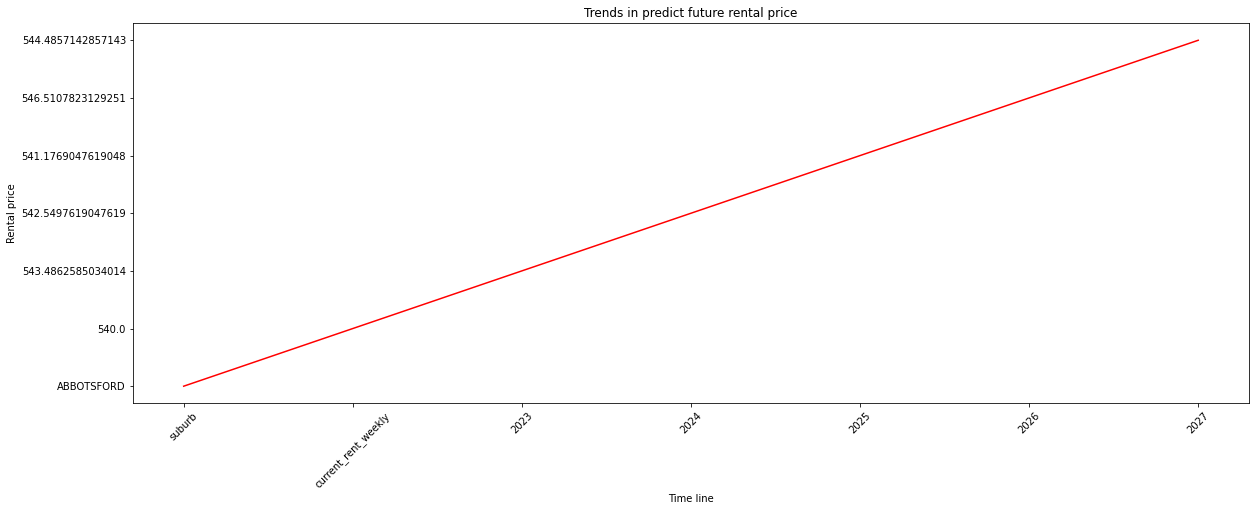

In [67]:
# plot the result
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Rental price")
plt.xlabel("Time line")
plt.title("Trends in predict future rental price")
plt.plot(result_group_by_suburb_df.columns.tolist(),\
    result_group_by_suburb_df.loc[0].tolist(), color = 'r')

In [68]:
# calculate growth rate
growth_rate_df = pd.DataFrame()

# get current year and end year
now_rent = result_group_by_suburb_df['current_rent_weekly']
end_rent = result_group_by_suburb_df['2027']

# calculate growth rate and use % as unit
growth_rate_df['suburb'] = result_group_by_suburb_df['suburb']
growth_rate_df['growth_rate_median (%)'] = ((end_rent-now_rent)/now_rent)*100

# descending the dataframe according to the value of growth rate
growth_rate_df.sort_values('growth_rate_median (%)',inplace=True, ascending=False)

# show top 20 
growth_rate_df.head(20)

,suburb,growth_rate_median (%)
46,BAMAWM EXTENSION,61.209351
527,TORRUMBARRY,43.922780
255,GILBERTON,40.854978
199,DONALD,39.842857
512,TANGAMBALANGA,35.964286
510,TALLAROOK,35.202857
194,DIAMOND CREEK,34.649351
433,OUYEN,33.496429
13,ALLAMBEE RESERVE,28.542857
499,STRATFORD,25.779791


In [69]:
# calculate future 3 years growth rate
growth_rate_df = pd.DataFrame()

# get three years
now_rent = result_group_by_suburb_df['current_rent_weekly']
end_rent = result_group_by_suburb_df['2025']

# calculate growth rate and use % as unit
growth_rate_df['suburb'] = result_group_by_suburb_df['suburb']
growth_rate_df['growth_rate_median (%)'] = ((end_rent-now_rent)/now_rent)*100

# descending the dataframe according to the value of growth rate
growth_rate_df.sort_values('growth_rate_median (%)',inplace=True, ascending=False)

# show top 20
growth_rate_df.head(20)

,suburb,growth_rate_median (%)
46,BAMAWM EXTENSION,58.744589
527,TORRUMBARRY,45.706564
199,DONALD,40.692857
512,TANGAMBALANGA,37.992857
255,GILBERTON,36.458874
510,TALLAROOK,34.928571
433,OUYEN,34.827381
499,STRATFORD,28.478978
194,DIAMOND CREEK,28.015584
562,WURRUK,26.322344
